In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

In [3]:
# function for numerical scheme in custom package 
from euler_scheme_1d_with_growth.analytical_solutions import steady_solution, nrect
from euler_scheme_1d_with_growth.functions_for_numerics import *

In [4]:
# GROWTH RULE
import euler_scheme_1d_with_growth.two_morph as two_morph
from euler_scheme_1d_with_growth.growth_rules import two_morph_growth_rule as growth_rule

In [5]:
default_figsize = plt.rcParams['figure.figsize']

# Parameters

## Diffusion

In [6]:
# assume to be 1
D     = 1
beta  = 1
alpha = 1
lam   = math.sqrt(D/beta) 

# supported by experiments
x0    = 0.4*lam 
w     = 0.4*lam

# minimal anitial size: minimal possible x0 + w, minimal plausible 2 * (x0 + w/2), minimal prefered (2 * x0 + 2 * w)
L0    = 1.8 * lam

In [7]:
steady_solution( 2.632792792792793/2, x0, lam, alpha, w, beta, D, 2.632792792792793 )

np.float64(0.13788951200208277)

In [8]:
thresholds_to_test = np.linspace(0.13788951200208277, 0.22, 5)
# for plotting
Lfinals = np.linspace(0, 4 , 100)

## Parameters for simulations

In [9]:
small_number = 1e-6

# space x
ndx  = 500
dx   = L0/ndx

# time t
tmax         = 10
dt           = 0.5*1e-5
t            = np.arange(0, tmax+small_number, dt)
ndt          = len(t)

# save only ndt_to_save time points
ndt_to_save = 1000

In [10]:
D * dt / dx**2

0.3858024691358025

# Lfinal(threshold)

In [11]:
thresholds = np.array( [
    two_morph.threshold_vs_Lfinal(Lfinal, x0, lam, alpha, w, beta, D) 
    for Lfinal in Lfinals] )

In [12]:
print( thresholds_to_test )
Lfinals_to_reach   = np.array([
    two_morph.Lfinal(threshold, x0, lam, alpha, w, beta, D) for threshold in thresholds_to_test
])

[0.13788951 0.15841713 0.17894476 0.19947238 0.22      ]


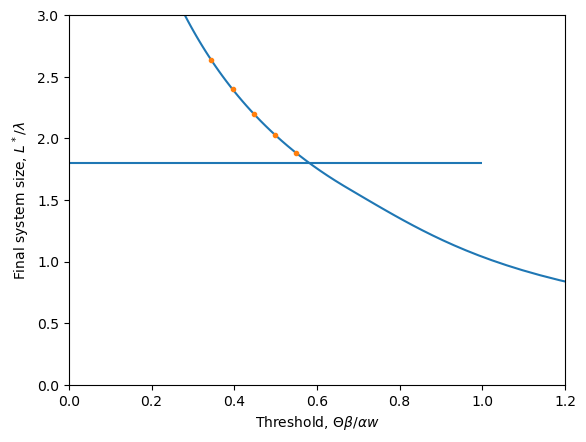

In [13]:
plt.plot( thresholds*beta/alpha/w, Lfinals/lam )
plt.plot( thresholds_to_test*beta/alpha/w, Lfinals_to_reach/lam, '.' )
plt.hlines(L0, 0, 1)
plt.xlabel(r'Threshold, $\Theta \beta / \alpha w$')
plt.ylabel(r'Final system size, $L^*/\lambda$')
plt.xlim( 0, 1.2 )
plt.ylim( 0, 3 )
plt.show()

## Chosen growth rate, threshold

In [14]:
g_to_test = np.array([0.5, 1, 2]) * beta

In [15]:
g = g_to_test[0]
threshold_growth = thresholds_to_test[0]

In [16]:
g

np.float64(0.5)

In [17]:
threshold_growth

np.float64(0.13788951200208277)

# Simulation

In [18]:
from euler_scheme_1d_with_growth.two_morph import *

In [19]:
threshold_growth = thresholds_to_test[0]

In [20]:
print(f'th_{threshold_growth}_g_{g}')
simulation = two_morph_euler_steady(D, beta, alpha, L0, x0, w, g, threshold_growth, ndx, dx, tmax, dt, t, ndt, ndt_to_save)
simulation.run_simulation()

th_0.13788951200208277_g_0.5


100%|██████████████████████████████| 2000000/2000000 [02:01<00:00, 16417.61it/s]


In [21]:
time_to_save = simulation.time_to_save
Lt = simulation.Lt

x_centerst = simulation.x_centerst
x_gridt = simulation.x_gridt

s_steadyt = simulation.s_steadyt
f_steadyt = simulation.f_steadyt

#st = simulation.st
#ft = simulation.ft

source_st = simulation.source_st
source_ft = simulation.source_ft

grt = simulation.grt

grsizet = simulation.grsizet

# Plot results

## System size

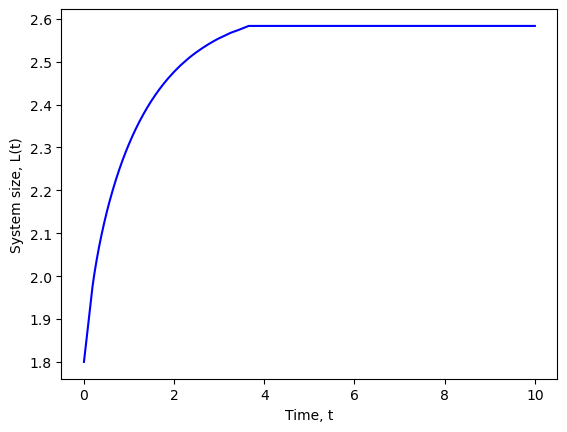

In [22]:
plt.plot( time_to_save, Lt, 'b')
#plt.ylim(0, 2*L0)
plt.xlabel('Time, t')
plt.ylabel('System size, L(t)')
plt.show()

## Relative growth region size

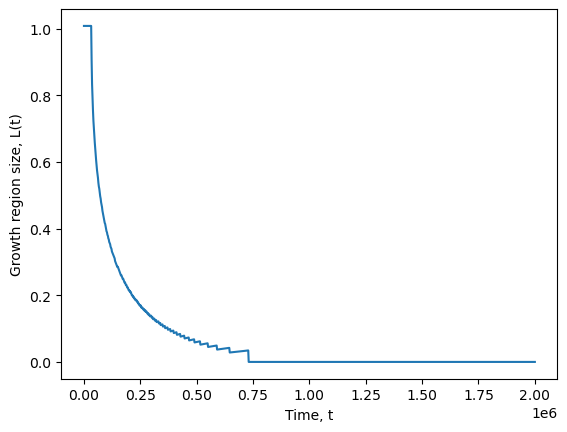

In [23]:
plt.plot(np.linspace(1, ndt, ndt_to_save).astype(int), grsizet / Lt)
#plt.ylim(0, 1)
plt.xlabel('Time, t')
plt.ylabel('Growth region size, L(t)')
plt.show()

## Morphogen gradient profiles for three picked time points

- t0: gap between sources is ~w
- t1: the relative growth region is ~1/2 of the relative growth region at t0
- t2: growth has stopped

In [24]:
from matplotlib_defaults import *

### Picking these time points

In [25]:
def plot_concentration(ax, n, i):
    ax.fill_between(x_centerst[n], source_st[n], color="red", alpha=0.5)
    ax.fill_between(x_centerst[n], source_ft[n], color="blue", alpha=0.5)
    ax.fill_between(x_centerst[n], threshold_growth * grt[n], color="green", alpha=0.5)
#    ax.plot(x_centerst[n], st[n], 'r', label='Source term (st)')
#    ax.plot(x_centerst[n], ft[n], 'b', label='Source term (ft)')
    ax.plot(x_centerst[n], s_steadyt[n], 'r', label='Steady state (st)')
    ax.plot(x_centerst[n], f_steadyt[n], 'b', label='Steady state (ft)')
    ax.set_title(f't = {round(time_to_save[n], 2)}')
    ax.set_xlabel('Position, x')
    ax.set_ylabel('Concentration, c(x)')
    ax.set_ylim(0, 0.4)

In [26]:
def mask_middle_zeros(arr):
    
    if not isinstance(arr, np.ndarray):
        arr = np.array(arr)
    
    # Identify the indices where transitions between 0 and 1 occur
    boundaries = np.where(np.diff(np.concatenate(([1], arr, [1]))))[0]
    
    # Find the groups of zeros
    zero_groups = [
        (start, end)
        for start, end in zip(boundaries[:-1], boundaries[1:])
        if arr[start:end].all() == 0
    ]
    
    if len(zero_groups) < 1:
        raise ValueError("The array does not contain a middle group of zeros.")
    
    # Select the middle group of zeros
    if len(zero_groups) != 1:
        mid_group = zero_groups[len(zero_groups) // 2]
    else:
        mid_group = zero_groups[0]

    # Create the mask
    mask = np.zeros_like(arr, dtype=bool)
    mask[mid_group[0]:mid_group[1]] = True

    return mask

In [27]:
gaps = []
for n in range(0, len(time_to_save)):
    if 2 not in source_st[n] + source_ft[n]: # no overlap between sources
        gap_mask = mask_middle_zeros(source_st[n] + source_ft[n])
        
        gaps.append( 
            float( np.sum( gap_mask * x_gridt[n] ) )
        )
    else:
        gaps.append( np.nan )
gaps = np.array( gaps )

In [28]:
def find_closest_index(array, value):
    array = np.array(array)  # Ensure input is a numpy array
    # Mask NaN values
    valid_mask = ~np.isnan(array)
    valid_array = array[valid_mask]
    
    if valid_array.size == 0:
        raise ValueError("The array contains only NaN values.")
    
    # Find the index of the closest value in the valid array
    closest_index_in_valid = np.argmin(np.abs(valid_array - value))
    
    # Map back to the original array index
    original_index = np.where(valid_mask)[0][closest_index_in_valid]
    
    return int(original_index)

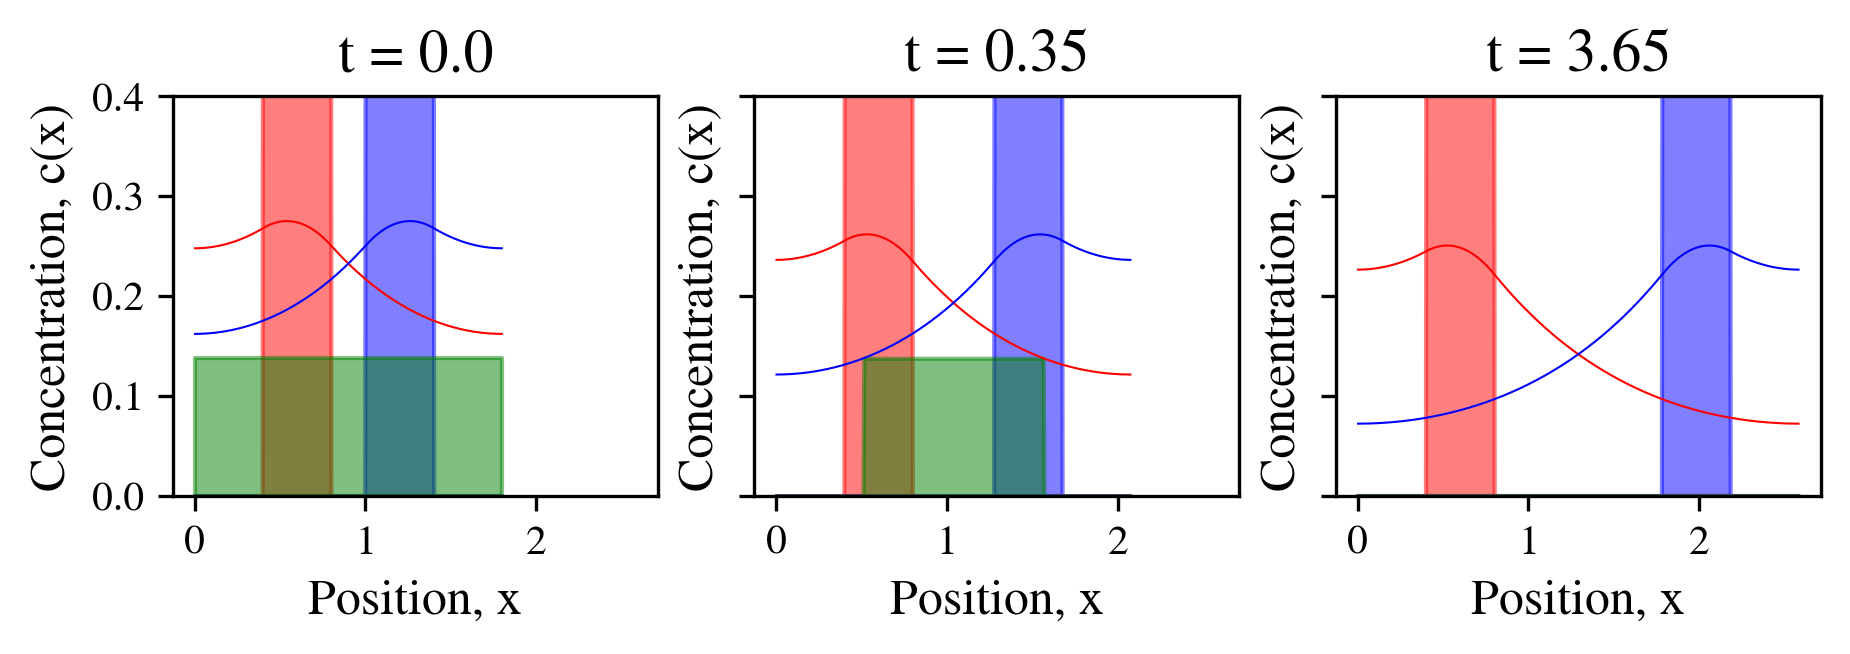

In [29]:
nrows, ncols = 1, 3
fig, ax = plt.subplots(nrows, ncols, figsize=(default_figsize["large"][0], default_figsize["large"][1]/5), sharex=True, sharey=True)
t_to_plot = np.arange(0, tmax+small_number, tmax/nrows)

i = 1
ax = plt.subplot(nrows, ncols, i)
# t0: the last moment then growth is in the whole system
#if len( np.argwhere( np.round( grsizet / Lt, 1 ) == 1) ) == 0:
#    nt0 = 0
#else:
#    nt0 = np.argwhere( np.round( grsizet / Lt, 1 ) == 1)[-1][0]
nt0 = 0

plot_concentration(ax, nt0, i)

i = 2
ax = plt.subplot(nrows, ncols, i)
# t1: the relative growth region is ~1/2 of the relative growth region at t0
nt1 = find_closest_index( (grsizet / Lt) / (grsizet / Lt)[nt0], 0.5 )
plot_concentration(ax, nt1, i)

i = 3
ax = plt.subplot(nrows, ncols, i)
# t2: growth has stopped
if len(np.argwhere( grsizet == 0 )) == 0:
    nt2 = len(grsizet)-1
else:
    nt2 = np.where( grsizet == 0 )[0][0]
    
plot_concentration(ax, nt2, i)

plt.savefig('fig/two_morph_profiles_t0_t1_t2_steady.pdf', bbox_inches='tight')

plt.show()

## Cartoons

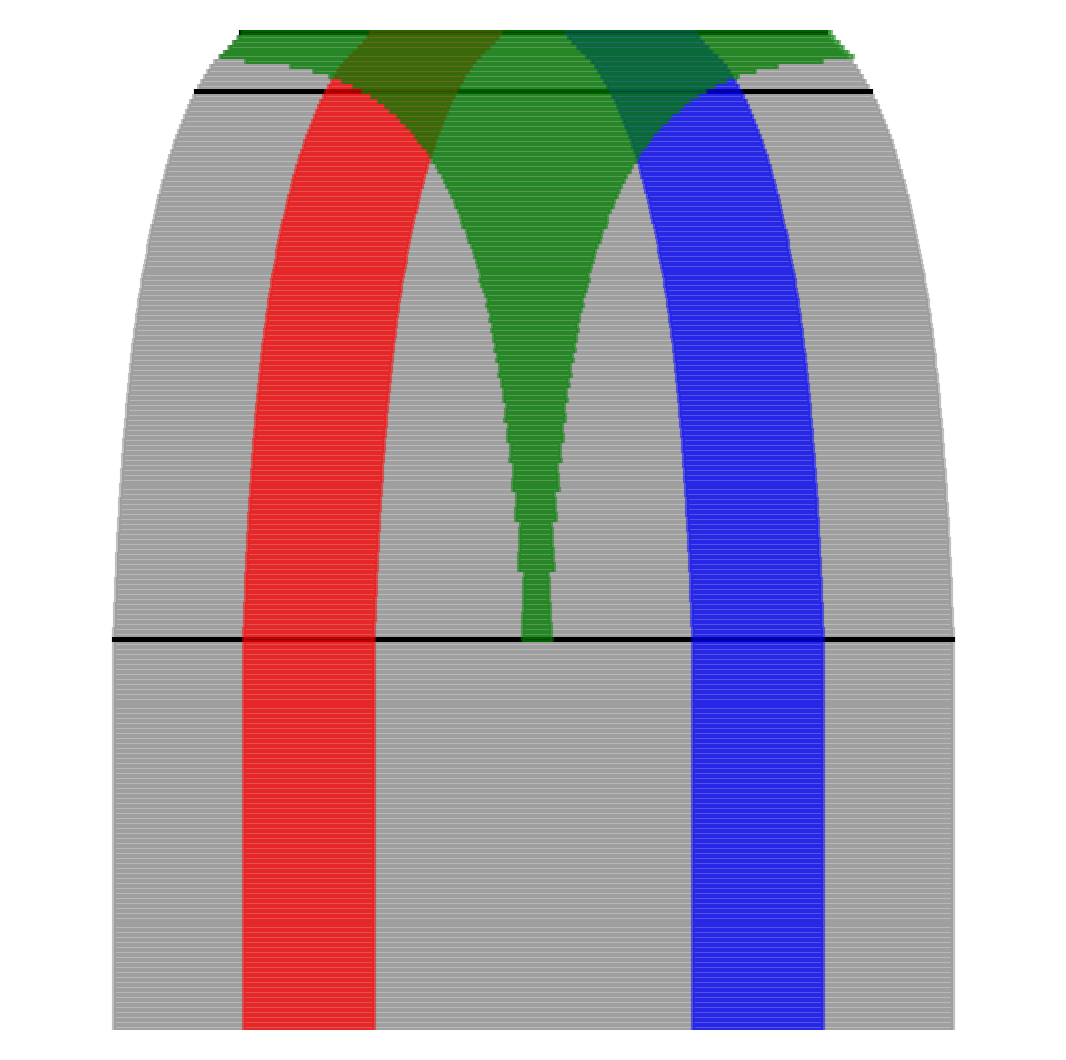

In [30]:
nrows, ncols = 201, 1
fig, ax = plt.subplots(nrows, ncols, figsize=(default_figsize["medium"][0], default_figsize["medium"][0]), sharex=True, sharey=True, gridspec_kw={'hspace': 0})
#t_to_plot = np.arange(0, time_to_save[nt2+50] + small_number, time_to_save[nt2+50]/nrows)
t_to_plot = np.arange(0, 0.6*tmax+small_number, 0.6*tmax/nrows)

# characteristic time points
n_to_plot = []
for i in range(1, ncols*nrows+1):
    n = int(t_to_plot[i - 1] / dt / (ndt / ndt_to_save))
    n_to_plot.append( n )

nt = [ 
    n_to_plot[find_closest_index( n_to_plot, nt0 )], 
    n_to_plot[find_closest_index( n_to_plot, nt1 )], 
    n_to_plot[find_closest_index( n_to_plot, nt2 )] 
]

middle = 0
for i in range(1, ncols*nrows+1):
    ax = plt.subplot(nrows, ncols, i)
    n = int(t_to_plot[i - 1] / dt / (ndt / ndt_to_save))
    
    # shift to maintain the growth zone middle at the same position        
    if grsizet[n] != 0:
        x0gr = x_centerst[n][ np.nonzero( grt[n] )[0][0] ]  # Center position of the green rectangle
        x_start = middle - Lt[n]/2

    if n in nt:
        ax.add_patch(plt.Rectangle( (x_start, 0), Lt[n], 1, color='black' ))
    else:
        ax.add_patch(plt.Rectangle( (x_start, 0), Lt[n], 1, color='gray', alpha=0.5))
        
    ax.add_patch(plt.Rectangle( (x_start+x0, 0),         w,     1, color='red',  alpha=0.5))
    ax.add_patch(plt.Rectangle( (x_start+Lt[n]-w-x0, 0), w,     1, color='blue', alpha=0.5))

    if grsizet[n] != 0:
        x0gr = x_centerst[n][ np.nonzero( grt[n] )[0][0] ]
        ax.add_patch(plt.Rectangle((x_start + x0gr, 0), grsizet[n], 1, color='green', alpha=0.5))

    #ax.plot(x_centerst[n], grt[n])data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABCoAAAQkCAYAAAC7X/+6AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAC4jAAAuIwF4pT92AAC/L0lEQVR4nOz9zY8bWbrnef6OHZqbk4qkwql7I3SdEQU1cKvpKiizs4GawUCDC8xm0PBFrWcxi97HLoEqIJe9ntnn/1DA3fuqgR4Mmkg0MKhppnLkXMykT5WYJelWuCSGy3nNjOecXpiRenHXm/shaXR9P3dhvAznY+c5doR0Pn7sMRNCCAIAAAAAAGiAZNMDAAAAAAAAWKBQAQAAAAAAGoNCBQAAAAAAaAwKFQAAAAAAoDEoVAAAAAAAgMagUAEAAAAAABqDQgUAAAAAAGgMChUAAAAAAKAxKFQAAAAAAIDGoFABAAAAAAAag0IFAAAAAABoDAoVAAAAAACgMShUAAAAAACAxqBQAQAAAAAAGoNCBQAAAAAAaAwKFQAAAAAAoDEoVAAAAAAAgMagUAEAAAAAABqDQgUAAAAAAGgMChUAAAAAAKAxKFQAAAAAAIDGoFABAAAAAAAag0IFAAAAAABoDAoVAAAAAACgMShUAAAAAACAxqBQAQAAAAAAGoNCBQAAAAAAaAwKFQAAAAAAoDEoVAAAAAAAgMZobXoAAABsmxdnL/S7f/ydJOmPT/8YNbbxXrdOTyVJO+fnUWPH4pTor+XfSZJe+V998OdCYqufT1uSzDqG9kU6nUKS1Ou9VpKE6PF3d3f1229/qx9//FG//4ff69bOrejnAADgJmJHBQAAAAAAaAx2VAAAEMGve79WK7n+/6yaudO3zx5LkrIXzyRJRe+OQtKcHQmlt3LTfylJmp//jSTpu90XssZLkuys2gnibn0jScrv3FFImvG3keCNfj7dkSR9n+aSpPu9l7KtSDsqgvTyl5f6S/GXOPEAAPgKUagAACCCVtJS1squHceEUjumumUiC9WX+2BbUn0bRRMYY9Uy1Zd9G6rjTtKSNUEKXq1QjXWu6uht2pjxOyMlobpO1lTFidRmSiMVKrz3sqYZuQIAsK2a8ecNAAAAAAAAUagAAAAAAAANQqECAAAAAAA0Bj0qAACIYO7n0vz6cYxzKoKrXtfNKUs3V6jfa4LSW81D9WhPZ6pj4efLZprOVGN1qo6lKxsz/uCNvKkak7o6h9Ll8iZeM03XkFwBANhWFCoAAIjgT6d/ihLHeK9b6akkaWevenqGwpnUoO++Tomedf9ZkvT6m19Jkt55xkX1lkLyX6qfD0+qLpZNsVcdfFoVKvLT10qSSIUKAABwbdz6AQAAAAAAGsOEEPgTAgAAn+HF2Qv97h9/J0n649M/Ro9vvNet03o3xfl59PixOSX6a/l3kqRX/lfL90P9KFKXtiQ1aCfFB3Q61c6KXm81Oyt2d3f1229/qx9//FG//4ff69bOrejnAADgJmFHBQAAAAAAaAx6VAAAcA2/7v1arSTO/5yaudO3zx5LkrIXzyRJRe+OQtLMXQmlt3LTfylJcud3ZMpSd9N/UrjVkSTld+4oJM38m0jwRj+f7kiSvk9zSdL93kvZVrymmi9/eam/FH/59M8CAIB3UKgAAOAaWklLWSuLEsuEUjumum0iC9UX/GBbUn0rRdMYY9Uy1Zf9xO8o8UY7wSqoGq+3aWPH7oyUhOq62fqJH6nNlEYqVHjvZU0zcwcAoOma+WcOAAAAAADwVaJQAQAAAAAAGoNbPwAAuIa5n0vzOLGMcyqCq14bL0kq3Vyhfq9pSm81D9UTM3xSKCSlCuMUVI23dGVjxx68kTdV7w9X51C6XN7E61HhGpo7AABNR6ECAIBr+NPpn6LFMt7rVlo/nnSvfjxpOJMa+n3XKdGz7j9Lks6+qR5P+oveejxpeFI1g2iqverg06pQkZ+u5vGkAADgy3DrBwAAAAAAaAwTQuBPBwAAfERRFPof/5//o/79f/r3evnypY7/+ThqfOO9bp3WOynOz6PGXjWnRH8t/06S9Mr/6s1uirQlqcG7KS7R6VQ7K3q91eys2N3d1W+//a1+/PFH/f4ffq9bO7einwMAgJuAHRUAAAAAAKAx6FEBAMAV7Ozs6OBXB7LGXjuWmTt9++yxJCl78UySVPTuKCTN35FQeis//XvZ2bl88XfyOzv6rv1S87/pKSTN/3tI8EY/n+5Ikr5Pc0nS/d5L2Va8ppovf3mpvxR/iRMPAICvAIUKAACuwBij1KZKk/T6sUKpnbrgkYXqy32wLSm5fhFk1YyxskrV8qms35HxO9qRlbHpVozfGSkJmSTJ1k/8SG2mNFKhwnsfpZgFAMDXpPl/6gAAAAAAAF8NChUAAAAAAKAxKFQAAAAAAIDGoEcFAABXEEJQ6Up5768dyzinIrjqtanilW6uUL/XZKW3ciqlpJRLCvlEKuQ0d+VWjD94I2+qpqUuVI8nLV0ub+I103RbMA8AADQJhQoAAK6gKAqNfh5FiWW81630VJK0s3devRnOpC34fuuU6Gn3n6Wu9Iv/J4XE6kySC/+p6lS5Dfaqg0+rQkV++lpJEqlQAQAAvhi3fgAAAAAAgMYwIQT+ZAAAwAe8OHuh3/3j7yRJf3z6x6ixjfe6dVrvpDg/jxp73WbtW3o2+1sV7bbOZ9mmh3NlnU61q6LXW82uit3dXUnSv/n1v5G1Vv/u4b/TrZ1b0c8DAMA2Y0cFAAAAAABoDHpUAADwhX7d+7VayfX/J9TMnb599liSlL14JkkqencUku3o7WB80M7pz5KkM/t3+g8v/l65/Vs9e9GWJN3pFTJb0OsheKOfT3ckSd+nuSTpfu+lbCteQ81fzn6RC07/Wf85TkwAAG4wChUAAHyhVtJS1rr+7Q0mlNoxVpKUhWqTY7AtKbHXjr0Wxi3HXZiWWiHV3KRKQjU3LRtkt2DvpjNajtnWT/tIbaY0UqHCe6+W4VcuAAA+1xb8+gAAAAAAAL4WFCoAAAAAAEBjUKgAAAAAAACNwQ2TAAB8obmfS/PrxzHOqQiuem28JKl0c4X6vaYzPizHXYS55qaUC6W8qRpSzl0ptwVPQQ/eyJuqgakL1eNJS5fLm3jNNOdhLhectB19UgEA2CgKFQAAfKE/nf4pShzjvW6lp5Kknb3z6s1wJm1HnaKyVx1mO3/Vs71Sxc6JzveqxpRnQduTS52HT6tCRX76WskKnliyu7sbPSYAADcNt34AAAAAAIDGMCFswZ5MAADW7MXZC/3uH38nSfrj0z9Gj2+8163TejfF+Xn0+OtSdDqSpNe9nkKSyHuj09NbkqTz851NDu1aOp1qZ0Wvt7qdFb/99rf68ccf9ft/+L1u7dyKfg4AALYVOyoAAAAAAEBj0KMCAIDP9Over9VK4vxPp5k7ffvssSQpe/FMklT07igkze+2aHzQzunPkqQ8/V6S9LJ3X6Fl5eZGj599K0l69qLqVXGnV8isYFdCbMEb/Xxa7QL5Pq0agt7vvZRtxWuq+fKXl/pL8Zc48QAAuKEoVAAA8JlaSUtZK4sSy4RSO8ZKkrJQbXAMtiUlNkr8lTLuzZgXOdhUoZWqDEbWVF/2k1DNVcsG2S3Yw+nMmzHb+okfqc2URipUeO9lzRZcXwAANmwLfm0AAAAAAABfCwoVAAAAAACgMShUAAAAAACAxqBHBQAAn2nu59I8TizjnIrgqtfGS5JKN1eo32sy48NyzIscclcqGC/njFyoHu3pTdUYdO5KuS14GnrwZjnmRQ6ly+VNvGaabguuLwAAm0ahAgCAz/Sn0z9Fi2W81630VJK0s3devRnOpG35HrtXHYq0Kli8Ps0VkkTeG52mtyRJ53tVU82zoK3Ly6dVoSI/fa1kC55YAgDATcKtHwAAAAAAoDFMCFuwFxMAgDV5cfZCv/vH30mS/vj0j9HjG+9167TeSXF+Hj3+uhSdjiTpda+nkFz8u4f3Rqen9c6K8521ji2mTqfaWdHrrWZnxe7urn777W/1448/6vf/8Hvd2rkV/RwAAGwbdlQAAAAAAIDGoEcFAACf8Over9VK4vxPppk7ffvssSQpe/FMklT07igkJkr8VTI+aOf0Z0lSnn4vSXrZu6/Qshd+1s2NHj/7VpL07EUmSbrTK2S2oN9D8EY/n1a7QL5Pc0nS/d5L2Va8ppovf3mpvxR/iRMPAIAbhkIFAACf0EpaylpZlFgmlNox1Rf7LFQbG4NtScnFL/uNY9ybMS9ysKlCK73wo2Uwsqb6sp+Eau5aNshuwV5OZ96M2dZP/EhtpjRSocJ7L2u24HoDALAhW/DrAgAAAAAA+FpQqAAAAAAAAI1BoQIAAAAAADQGPSoAAPiEuZ9L8zixjHMqgqteGy9JKt1coX6vyYwPyzEvcshdqVC/9zbnjFyoHu3pTdUodO5KuS14KnrwZjnmRQ6ly+VNvGaabguuNwAAm0KhAgCAT/jT6Z+ixTLe61Z6Kkna2Tuv3gxn0rZ8b92rDkVaFSden+YKycUNmt4bnaa3JEnne1VTzbOgrcvTp1WhIj99rWQLnlgCAMBNwK0fAAAAAACgMUwIW7AHEwCAFTv564n+q//rf1X9P/fixzeS/kX9+tv44dfqZX38j5I+/kvE15n1lZ1I//bf/lv9D//n/0G3dm6t5hwAAGwBdlQAAAAAAIDGoEcFAAAfMlG0ngqJpB/r14s9Bv85XviVs5L+rn79H+vjE31q/F9n1l98in68cAAA3AQUKgAA+BAn6eIDLa7EqPpOKknpe+9vi8W4F3l8euxfZ9YAAOB6uPUDAAAAAAA0BoUKAAAAAADQGBQqAAAAAABAY9CjAgCAD7Gf/pHPFfSmBWP53vvbYjHuRR6fHvvXmfUXibjGAAC4KShUAADwIRGfxuAl/af69S/xwq7VaX18WR8/3Wf068waAABcD7d+AAAAAACAxjAhhG3afwkAQFQvzl7od//4O0nSH5/+MXp8471unVZ/ld85P48ef52KTkeS9LrXU0g+/28d3hudnt6SJJ2f76xkbOvS6RSSpF7vtZIk/q9Qu7u7+u23v9WPP/6o3//D73Vr51b0cwAA0HTsqAAAAAAAAI1BjwoAAN7z696v1Uri/E+kmTt9++yxJCl78UySVPTuKCQmSvxVMz5o5/RnSVKefi9Jetm7r9D6/C6Qbm70+Nm3kqRnLzJJ0p1eIbOCHQmrELzRz6fVTpDv01ySdL/3UrYVafxBevnLS/2l+EuceAAAbDkKFQAAvKeVtJS1siixTCi1Y6ov9VmoNjIG25KSLXncg3Fvxr3Iw6YKrfSzQ5TByJrqi34Sqnlt2SC7Jfs6nXkzbmuq4kRqM6WRChXee1mzJesBAIA12JJfEQAAAAAAwNeAQgUAAAAAAGgMChUAAAAAAKAx6FEBAMB75n4uzePEMs6pCK56bbwkqXRzhfq9pjM+LMe9yCN3pUL93udwzsiF6rGe3lRNROeulNuSJ6QHb5bjXuRRulzexGum6bZkPQAAsA4UKgAAeM+fTv8ULZbxXrfSU0nSzt559WY4k7bpe+ledSjSqjjx+jRXSD5/U6b3RqfpLUnS+V7VVPMsaCvnwKdVoSI/fa1kS55aAgDAtuHWDwAAAAAA0BgmhC3ZdwkAQERFUWg4HEqSTk5OPvhzuc91ND2SJB3/8/Fnxzfe69ZpvZPi/PzqA22AotORJL3u9b5oJ8X7vDc6Pa13VpzvRBnbpnQ61c6KXu/LdlYc7B5Ikg67h8qSyx+Be+/ePUnSw4cPtbOz3fMEAMBVsKMCAAAAAAA0Bj0qAACo7e/vy1r7znszN1P3SVeSlIXqL+CDbwayxl74/NvM3OnbZ4+rz714JkkqencUEhN72CthfNDO6c+SpDz9XpL0sndfofXxvD/GzY0eP/tWkvTsRTWXd3qFzJb0egje6OfTaofD92kuSbrfeynb+vj4XXAan40lSd1utZb6P/TVtu03P+Oc/vrXv65i2AAAbB0KFQAA1Ky1FwoVVlZJfbuDqZ/8kNpUaZJ+NJYJpXbqYkYWqs8H25KSq3/RXyvj3ox7kYdNFVofz/tjymBkTfVFP6mLPi0bZLdkf6czb8Zt6yd+pDZT+olCRenL5dpZrKXL1hoAAKhsya8GAAAAAADga0ChAgAAAAAANAaFCgAAAAAA0Bj0qAAAoOacu/Q9770kafFE79KVy/c+xDinIlTxjPH15+YK4eI5msj4sBz3Io/clQrm43l/jHNGLlSP9fR1z4a5K+W25EnpwZvluBd5lC6XN59uprlYO4t145yT05u1cNnaAwDga0WhAgCA2mVPXch9rul0Wr3Oqyc9jPLRJ2MZ73UrPZUk7eydV2+GM2mbvo/uVYcirb5cvz7NFZKrb8b03ug0vSVJOt+rmmqeBW3lnPi0KlTkp6+VfMFTSxZrafJkoizJog8PAICbgFs/AAAAAABAY5gQtmS/JQAAkRRFoeFwKEk6OTm5drzc5zqaHkmSjv/5uNpNcVrvpjg/v3b8TSk6HUnS617vWjsp3ue90elpvbPifCda3HXrdKpdFb1etaviYPdAknTYPYyyW+LevXuSpIcPH2pnZ3vnCQCAL8WOCgAAAAAA0Bj0qAAAQNL+/r6stVf67MzN1H3SlSRlIZO81387/15pSJS9eCZJKnp3FBITbbyrYnzQzunPkqQ8/V6S9LJ3X6F1tbm5jJsbPX72rSTp2Ytq58GdXiHzBb0eNiV4o59Pq90N36e5vCmVZP+LkkTqdqs10P+hr7ZtXym+c+7SXikAAHxNKFQAACDJWnvlQoWVVVLfGmHqp0LsKFFqrLJQvR9sS0rifdlfGePejNlU481sqtBKo52iDEbWVF/2k1AVKlo2yG7BPk9n3ozZmiDJSDIyRss1cJ21BAAAuPUDAAAAAAA0CIUKAAAAAADQGBQqAAAAAABAY9CjAgAAVU0Mr/NZ770kafHU70JeIUjGVO+Xbq4Qrn6OdTE+LMdc1OPNXalQvxeDc0YuVI/29HVPj7kr5bbgienBm+WYXSiqZpoKCkHLNeCck9PVrvV11iEAADcFhQoAAKRrPWkh97mm02n1Os9lvNd/aJ1Kknb2zqsfCme64nfX9durDkVaffF+fZorJPE2YXpvdJrekiSd71VNNc+Ctm5+fFoVW3p5oSQJyzUweTJRlmSbGh0AAFuPWz8AAAAAAEBjmBC2YJ8lAAARFEWh4XAoSTo5OYkev5XnenB0JEm6e3ysc+v1h/vVzorhd+fRz7cqRacjSXrd60XdSfE+741OT+udFec7KztPbJ3nDyVJvcc/KXEdHRw8lSQdHj5Sls2jn+/evXuSpIcPH2pnZ3vmCQCAq2JHBQAAAAAAaAx6VAAAvmr7+/uy1kaJlcxm6na7kqQsyzS3XvPvv1dIjFznuSTpN7Oe0tC8vxMYH7Rz+rMkKU+/lyS97N1XaMWZm8u4udHjZ99Kkp69qHo63OkVMknzNnt6U+q0PZIkfWdLBW+U/P92lLhsec37/b7a7ThNR51z1+qbAgDANqNQAQD4qllr4xUqrFVS3yphjJExkmwik1gZU72/k6RKtbov/1dmnLK6gBJMNb7MpgqtdGWnLIORNdWtDEmoChUtG2SbV8eRk1FSP+2jZY2ckWSMjDHLa16tJbPBUQIAcDM08FcBAAAAAADwtaJQAQAAAAAAGoNCBQAAAAAAaAx6VAAAvmrOuWixgnPyvmqmGEJQCJKcr19X7xe+VAjxzhmL8UHG1GOsx5e7UsHEaQ55GeeMXCgkSb7u/zB3pVwDn5zuTSlfj2vuQtVMMwSFEJbX3Dkn5+I10wQA4GtFoQIA8FWL+WSFVp5rbzqVJHXyXIX1aj07lSTZ784lSX/WWbTzRbdXHYq0+rL9+jRXSFa3+dJ7o9P0liTpfK9qqnkWJDX1O/ovVZNR/7xqMNrLCyWupWl9zSeTibJsvrHhAQBwU3DrBwAAAAAAaAwTQgP3VwIAEFlRFBoOh5Kkk5OTqLFbea4HR0eSpLvHxx/8uXPr9Yf71Q6LYb3DommKTkeS9LrXW+luigXvjU5P610V5zsrP99VdJ4/lCT1Hv+kxHU++HMHB08lSYeHj6LvrLh3754k6eHDh9rZaeY8AQAQCzsqAAAAAABAY9CjAgDw1drf35e19tpxktlM3W5XkpRlmSTp1WCg8F7smZmrvPNYkuQ6zyVJv5n1lIbN/t3A+KCd058lSXn6vSTpZe++Quv6c/Mpbm70+Nm3kqRnL6q5u9MrZJLNbvj0ptRpeyRJ+s6WkqT7OzO1gnnn55wzGo9vS9JyDfT7fbXb12+q6ZyL2kMFAIBtQaECAPDVstbGKVRYq6S+TcLUT68waSql6Ts/Z0wiY1vL15K0k6RKtfqCwEcZp6wulgRTjSWzqUIr/dinoiiDkTXVrQxJqAoVLRtkN7zn08koqa9ly1bHncwofa9QUZZmec0Xa6BaV+/+HAAA+Hzc+gEAAAAAABqDQgUAAAAAAGgMbv0AAHy1nHNR4gTn5H3Vk2DxMK1Qlgr+3T4FwcwV3Lz+ueq/Fb5UCHHGcVXGBxlTj6ceS+5KBXP9Pguf4pyRC4Ukyde3UMxdKbfhh5J5U8rXY5i76ljkYfnegnNvrvliDTjn5FycHhUAAHyNKFQAAL5asRoVtvJce9OpJKmT55Kk3dHows8F65XWjye19eNJ/6yzKGO4tr3qUKTVF+zXp/n6Hk+a1o8n3at6VZwFSU34jv5L1a/DP696dRSP20pc+5IfrK75tF4Dk8kk+uNJAQD4mnDrBwAAAAAAaAwTwob3VgIAsEJFUWg4HEqSTk5Oosdv5bkeHB1Jku4eH3/2586t1x/q3RXDenfFphWdjiTpda+3lt0UC94bnZ7WuyrOd9Z23k/pPH8oSeo9/kmJ63zWZw4OnkqSDg8frWRXxb179yRJDx8+1M5Oc+YKAICY2FEBAAAAAAAagx4VAICvzv7+vqy1UWIls5m63a4kKcsySdKrwUDhE/FnZq7yzmNJkus8lyT9ZtZTGtb7NwTjg3ZOf5Yk5en3kqSXvfsKrTjz8znc3Ojxs28lSc9eVHN4p1fIJOvf9OlNqdN21V/kO1tKku7vzNQK5oOfcc5oPL4tScu10O/31W7HaUbqnIvWTwUAgG1AoQIA8NWx1sYrVFirpL5NwtRPrTBpKqXpRz9nTCJjW8vXkrSTpEq1vgJBdXKnrC6OBFOdO7OpQuvj44+pDEbWVLcxJKEqVLRskN3Avk8no6S+ji1bHXcyo/QjhYqyNMtrv1gL1Rr78GcAAMCHcesHAAAAAABoDAoVAAAAAACgMShUAAAAAACAxqBHBQDgq+OcixYrOCfvq6aJiyd+h7JU8B9vpBjMXMHN689VP1v4UiHEG9vnMD7ImPr89blzVyqYOI0gP4dzRi4UkiRf93qYu1JuA09Q96aUr887d9WxyMPyvcs49+baL9aCc07OxWumCQDA14RCBQDgqxPzCQqtPNfedCpJ6uS5JGl3NPrk54L1Su+fSpLsd+eSpD/rLNq4vshedSjS6ov169NcIVnfpkvvjU7TW5Kk872qqeZZkLSp7+e/VE1F/fOqoWjxuK3EtT/xoeraT+u1MJlMlGXzlQ0RAICbjFs/AAAAAABAY5gQNrCvEgCANSiKQsPhUJJ0cnISPX4rz/Xg6EiSdPf4+Eoxzq3XH+qdFcN6Z8W6FZ2OJOl1r7fWnRTv897o9LTeWXG+s7FxdJ4/lCT1Hv+kxHW++PMHB08lSYeHj1ayq+LevXuSpIcPH2pnZ3PzBADAqrCjAgAAAAAANAY9KgAAX5X9/X1Za6PESmYzdbtdSVKWZZKkV4OBwhfEn5m5yjuPJUmu81yS9JtZT2lY7d8SjA/aOf1ZkpSn30uSXvbuK7TizM1VuLnR42ffSpKevajm806vkElWv/nTm1Kn7aq3yHe2lCTd35mpFcxnfd45o/H4tiQt10S/31e7Ha+hZszeKgAANBmFCgDAV8VaG69QYa2S+lYJUz+twqSplKafHcOYRMa2lq8laSdJlWrFBQPjlNXFkGCqc2U2VWh9/thjK4ORNdWtDEmoChUtG2TXsP/TySipr2HLVsedzCj9zEJFWZrlGlisiWqtfd7nAQDAG9z6AQAAAAAAGoNCBQAAAAAAaAwKFQAAAAAAoDHoUQEA+Ko456LFCs7J+6pZ4uJp36EsFfznN1AMZq7g5nWM6nOFLxVCvHFexvggY+rz1efKXalg4jR/vArnjFwoJEm+7vcwd6XcGp6k7k0pX59n7qpjkYfle5/i3Js1sFgTzjk5F6+ZJgAAXwsKFQCAr0rMJye08lx706kkqZPnkqTd0eiLYgTrld4/lSTZ784lSX/WWbQxftRedSjS6sv069NcIdncZkvvjU7TW5Kk872qqeZZkLSu7+i/VE1F/fOqoWjxuK3Etb8gQLUGpvWamEwmyrJ51CECAPA14NYPAAAAAADQGCaENeynBABgzf7pn/5J33333cridyT9u/r1/ylCvFkq/fv/Y/X6/30vQsDP9LI+/kdJzfiFwEj6F/Xrb9d32pPfVsf/+f8ilV+yi+JD/qf6+H+XdB4h3uWeP3+uv/3bv11ZfAAANoEdFQAAAAAAoDHoUQEAQCT/i6Tyip8tVO1qkKRX9bE/kewK+jNYSX9Xv16c84nW1wri4xJJP9avFzsr/rNWMjrrqkmW9GYm/ihp54oBU0n/+2sPCwCArx2FCgAAIil19UJFKWnxfIjFLRjGSat6CEdaH+3iXKs5zRUYvRlV+t77qzjXYrYXE12u6FwAAOBzcesHAAAAAABoDAoVAAAAAACgMShUAAAAAACAxqBHBQAAkaSf/pEPCnrz14NFh4RgV/fI0EUvjUWLymY8mlSqRrIYVfne+5HZoDezvZj9VFe/ktdZAQAAYIFCBQAAkVzneQ8zSf//+vVpfTzrX288H7M4x8v6uKKenVfgJf2n+vUvazjf7fq4eMLI/0FSew3nBQAAH8KtHwAAAAAAoDFMCKE5uz0BAIigKAoNh0NJ0snJSfT4rTzXg6MjSdLd4+Oosc+t1x/uV/sdht+dR439vqLTkSS97vUUkub87cJ7o9PTW5Kk8/OdlZ6r8/yhJKn3+CclrhM19sHBU0nS4eEjZdk8amxJunfvniTp4cOH2tlZ7TwBALBOzfmtBAAAAAAAfPXoUQEA+Crs7+/LWhslVjKbqdvtSpKyLJMkvRoMFCLEn5m5yjuPJUmu81yS9JtZT2mI87cF44N2Tn+WJOXp95Kkl737Cq04cxODmxs9fvatJOnZi2p+7/QKmSTOJlBvSp22R5Kk72zVsPP+zkytYD72sc/inNF4XPW9WKyRfr+vdjtOFxDnnP76179GiQUAQFNRqAAAfBWstfEKFdYqqW+VMKb6cmvSVEqv/9QHYxIZ21q+lqSdJFWqSIUE45TVRY9gqpiZTRVazXliRRmMrKluZUhCVaho2SAbaR+ok1FSX7eWrY47mVEaoVBRlma5JhZrpFp7148NAMDXgls/AAAAAABAY1CoAAAAAAAAjUGhAgAAAAAANAY9KgAAXwXnXLRYwTl5XzVHXDzlO5Slgr9+w8Rg5gpuXseu4hW+VAhxxm98kDF13Dpm7koFE6fZYwzOGblQSJJ83e9h7kq5SE9U96aUr2PNXXUs8rB87zqce7MmFmvEOSfn4jXTBADgpqNQAQD4KsR8UkIrz7U3nUqSOnkuSdodjaLEDtYrvX8qSbLfnUuS/qyzKLGX9qpDkVZfnl+f5gpJczZZem90mt6SJJ3vVU01z4KkmN/Rf6kaifrnVRPR4nFbiWtHCl6tiWm9RiaTibJsHik2AAA3X3N+KwEAAAAAAF89E0KkfZQAADRAURQaDoeSpJOTk+jxW3muB0dHkqS7x8fR4y+cW68/1DsrhvXOipiKTkeS9LrXa9RuigXvjU5P610V5zsrOUfn+UNJUu/xT0pcZyXnODh4Kkk6PHy0kl0V9+7dkyQ9fPhQOzurmScAANateb+ZAAAAAACArxY9KgAAN97+/r6stVFiJbOZut2uJCnLMknSq8FAIVL8hZmZq7zzWJLkOs8lSb+Z9ZSGq/+NwfigndOfJUl5+r0k6WXvvkIr7thjcHOjx8++lSQ9e1HN851eIZNcbyOoN6VO21U/ke9sKUm6vzNTK5hrxX2bc0bj8W1JWq6Vfr+vdjteQ82YPVcAAGgaChUAgBvPWhuvUGGtkvpWCVM/kcKkqZSmUeIvGJPI2NbytSTtJKlSXSMP45TVhY5gqjiZTRVaccceQxmMrKluZUhCVaho2SB7zb2gTkZJfd1atjruZEZpxEJFWZrl2lislWoNxjsHAAA3Gbd+AAAAAACAxqBQAQAAAAAAGoNCBQAAAAAAaAx6VAAAbjznXLRYwTl5XzVFXDzhO5Slgo/TKHF5HjNXcPP6PFXswpcK4eq5GB9kTB2rjpO7UsHEHXsMzhm5UEiSfN3vYe5KuWs+Vd2bUr6OMXfVscjD8r0YnHuzNhZrxTkn5+I10wQA4CajUAEAuPFiPiGhlefam04lSZ08lyTtjkbR4i8E65XeP5Uk2e/OJUl/1tn1A+9VhyKtvjS/Ps0VkuZtsPTe6DS9JUk636uaap4FSTG+o/9SNRL1z6smosXjthLXjhD4bdXamNZrZTKZKMvmkc8BAMDN1LzfTAAAAAAAwFfLhBBxryMAABtUFIWGw6Ek6eTkJHr8Vp7rwdGRJOnu8XH0+O87t15/qHdVDOtdFTEUnY4k6XWv18jdFAveG52e1rsqzneixe08fyhJ6j3+SYnrRIv7IQcHTyVJh4ePVrKr4t69e5Kkhw8famcn3jwBALApzf3tBAAAAAAAfHXoUQEAuNH29/dlrY0SK5nN1O12JUlZlkmSXg0GCpHiv29m5irvPJYkuc5zSdJvZj2l4cv/zmB80M7pz5KkPP1ekvSyd1+htZqxx+DmRo+ffStJevaimu87vUIm+fLNoN6UOm1XvUS+s6Uk6f7OTK1g4gz2Pc4Zjce3JWm5Zvr9vtrteA01Y/ZeAQCgSShUAABuNGttvEKFtUrqWyVM/SQKk6ZSmkaJ/z5jEhnbWr6WpJ0kVaor5GOcsrrAEUz1+cymCq3VjD2GMhhZU93KkISqUNGyQfYK+0GdjJL6mrVsddzJjNIVFSrK0izXyGLNVGtxNecDAOAm4dYPAAAAAADQGBQqAAAAAABAY1CoAAAAAAAAjUGPCgDAjeacixYrOCfvq2aIi6d7h7JU8HEaJF44n5kruHl9vuochS8VwpfnZHyQMXWM+vO5KxXMasYeg3NGLhSSJF/3e5i7Uu4KT1b3ppSvPzd31bHIw/K92Jx7s0YWa8Y5J+fiNdMEAOCmolABALjRYj4ZoZXn2ptOJUmdPJck7Y5G0eK/L1iv9P6pJMl+dy5J+rPOrh5wrzoUafVl+fVprpA0d3Ol90an6S1J0vle1VTzLEi66nf0X6omov551UC0eNxW4trXHeZHVGtkWq+ZyWSiLJuv8HwAANwMzf3tBAAAAAAAfHVMCCva8wgAwBoVRaHhcChJOjk5iR6/led6cHQkSbp7fBw9/secW68/1DsrhvXOiqsqOh1J0uter9G7KRa8Nzo9rXdVnO9cO17n+UNJUu/xT0pc59rxPtfBwVNJ0uHho5Xsqrh3754k6eHDh9rZuf48AQCwSc3/DQUAAAAAAHw16FEBALix9vf3Za2NEiuZzdTtdiVJWZZJkl4NBgqR4n/MzMxV3nksSXKd55Kk38x6SsPn/b3B+KCd058lSXn6vSTpZe++Qmv1Y78uNzd6/OxbSdKzF9W83+kVMsnnbwj1ptRpu+ol8p0tJUn3d2ZqBRN3sO9xzmg8vi1Jy7XT7/fVbsdrqBmzBwsAAE1BoQIAcGNZa+MVKqxVUt8qYeonUJg0ldI0SvyPMSaRsa3la0naSVKl+szcjFNWFzWCqT6T2VShtfqxX1cZjKypbmVIQlWoaNkg+wV7Qp2MkvqatWx13MmM0hUXKsrSLNfKYu1Ua3K15wUAYNtx6wcAAAAAAGgMChUAAAAAAKAxKFQAAAAAAIDGoEcFAODGcs5FixWck/dVE8TFk71DWSr4OI0RP3puM1dw8/rc1fkKXyqEz8vP+CBj6s/Vn8ldqWBWP/brcs7IhUKS5Ot+D3NXyn3B09W9KeXrn5+76ljkYfneqjj3Zq0s1o5zTs7Fa6YJAMBNRKECAHBjxXwiQivPtTedSpI6eS5J2h2NosX/mGC90vunkiT73bkk6c86+7Ige9WhSKsvya9Pc4Wk+RsrvTc6TW9Jks73qqaaZ0HSl35H/6VqIuqfVw1Ei8dtJa4da5gfUa2Vab12JpOJsmy+hvMCALC9mv8bCgAAAAAA+GqYEFa87xEAgBUrikLD4VCSdHJyEj1+K8/14OhIknT3+Dh6/M9xbr3+UO+qGNa7Kr5U0elIkl73eluxm2LBe6PT03pXxfnOlWJ0nj+UJPUe/6TEdaKN7UscHDyVJB0ePlrJrop79+5Jkh4+fKidnavNEwAATbA9v6UAAAAAAIAbjx4VAIAbaX9/X9baKLGS2UzdbleSlGWZJOnVYKAQKf7nmJm5yjuPJUmu81yS9JtZT2n4+N8cjA/aOf1ZkpSn30uSXvbuK7TWN/brcnOjx8++lSQ9e1HN/51eIZN8fFOoN6VO21Ufke9sKUm6vzNTK5jVDfY9zhmNx7clabmG+v2+2u14DTVj9mIBAKAJKFQAAG4ka228QoW1SupbJUz95AmTplKaRon/OYxJZGxr+VqSdpJUqT6Ro3HK6mJGMNXPZjZVaK1v7NdVBiNrqlsZklAVKlo2yH5iX6iTUVJfr5atjjuZUbrGQkVZmuWaWayham2ubwwAAGwbbv0AAAAAAACNQaECAAAAAAA0BoUKAAAAAADQGPSoAADcSM65aLGCc/K+an64eKp3KEsFH6ch4meNwcwV3LweQ3XewpcK4eN5Gh9kTP3z9c/mrlQw6xv7dTln5EIhSfJ1v4e5K+U+8YR1b0r5+mfmrjoWeVi+tw7OvVkzizXknJNz8ZppAgBw01CoAADcSDGfhNDKc+1Np5KkTp5LknZHo2jxP0ewXun9U0mS/e5ckvRnnX3eh/eqQ5FWX45fn+YKyfZsqvTe6DS9JUk636uaap4FSZ/zHf2XqoGof141Dy0et5W49iqG+RHVmpnWa2gymSjL5mseAwAA22N7fksBAAAAAAA3nglhjfsfAQCIrCgKDYdDSdLJyUnU2K0814OjI0nS3ePjqLGv6tx6/aHeWTGsd1Z8jqLTkSS97vW2ajfFgvdGp6f1rorznS/6bOf5Q0lS7/FPSlwn+ti+xMHBU0nS4eGjleyquHfvniTp4cOH2tn5snkCAKAptu83FQAAAAAAcGPRowIAcOPs7+/LWnvtOMlspm63K0nKskyS9GowUIgQ+6pmZq7yzmNJkus8lyT9ZtZTGi7+7cH4oJ3TnyVJefq9JOll775Ca3Pjvyo3N3r87FtJ0rMX1bW40ytkkss3hnpT6rRd9RH5zpaSpPs7M7WCWf1g3+Oc0Xh8W5KW66nf76vdjtdQM2ZPFgAANo1CBQDgxrHWxilUWKukvk3C1E+bMGkqpem1Y1+VMYmMbS1fS9JOkirVJfkap6wuYART/ffMpgqtzY3/qspgZE11K0MSqkJFywbZD+wNdTJK6mvWstVxJzNKN1CoKEuzXD+L9VSt0fWPBQCAbcCtHwAAAAAAoDEoVAAAAAAAgMagUAEAAAAAABqDHhUAgBvHORclTnBO3lcNDxdP8w5lqeDjNEG80pjMXMHN6zFV4yh8qRAu5mx8kDH1z9T/PXelgtnc+K/KOSMXCkmSr/s9zF0p94GnrHtTytf/be6qY5GH5Xvr5Nyb9bNYT845ORevmSYAADcJhQoAwI0T6wkIrTzX3nQqSerkuSRpdzSKEvuqgvVK759Kkux355KkP+vswx/Yqw5FWn0pfn2aKyTbt6HSe6PT9JYk6Xyvaqp5FiR97Dv6L1UDUf+8ah5aPG4rce1VDvMjqvUzrdfTZDJRls03NBYAAJpt+35TAQAAAAAANxaFCgDA1iqKQsPhUJJ0cnKy2cGsSccl+ulxT5L08Hnnsz5TdKqfe93rbeVuCklKkqBe77UkqdMpPvtznecPJUm9xz8pcZ83X6t0fHxXknR09EB5Hn9j6+LfwXA4VFF8/jwBANAk2/nbCgAAAAAAuJHoUQEAuFH29/dlrY0SK5nN1O12JUlZlkmSXg0GCpHiX9XMzFXeeSxJcp3nkqTfzHpKw5u/PxgftHP6syQpT7+XJL3s3VdobXbs1+HmRo+ffStJevaiuh53eoVM8m6DTG9KnbarXiLf2VKSdH9nplYw6xvse5wzGo9vS9JyTfX7fbXb8RpqxurNAgDAplGoAADcKNbaeIUKa5XUt0qY+kkTJk2lNI0S/6qMSWRsa/laknaSVKneyts4ZXXhIpjq/cymCq3Njv06ymBkTdVIMwlVoaJlg+x7+0OdjJL6erVsddzJjNINFirK0izX0GJNVWt1c2MCAKCpuPUDAAAAAAA0BoUKAAAAAADQGBQqAAAAAABAY9CjAgBwozjnosUKzsn7qtlhCFXDxlCWCj5OA8SrCmau4ObV61CNpfClQniTu/FBxtT/rX4/d6WC2ezYr8M5IxeqR276ut/D3JVy4WIzTV+/N3fVscjD8r1NcO7NGlqsKeecnIvXTBMAgJuCQgUA4EaJ+eSDVp5rbzqVJHXyXJK0OxpFi39VwXql908lSfa7c0nSn3V28Qf3qkORVl+GX5/mCsn2bqb03ug0vSVJOt+rmmqeBUmXfUf/pWog6p9XzUOLx20lrr2OYX5EtYam9ZqaTCbKsvkmBwQAQCNt728rAAAAAADgxjEhbHAfJAAAV1QUhYbDoSTp5OQkevxWnuvB0ZEk6e7xcfT413Vuvf5Q76oY1rsqLlN0OpKk173eVu+mWPDe6PS03lVxvvPBn+s8fyhJ6j3+SYnrrGVsX+Lg4Kkk6fDw0Up2Vdy7d0+S9PDhQ+3sfHieAABoou3/jQUAAAAAANwY9KgAANwY+/v7stZGiZXMZup2u5KkLMskSa8GA4VI8a9rZuYq7zyWJLnOc0nSb2Y9pSGR8UE7pz9LkvL0e0nSy959hVYzxn4dbm70+Nm3kqRnL6rrcqdXyCRB3pQ6bVc9RL6zpSTp/s5MrWA2Mtb3OWc0Ht+WpOXa6vf7arfjNdSM2aMFAIBNoVABALgxrLXxChXWKqlvlTD1EyZMmkppGiX+dRmTyNjW8rUk7SSpUlnJOGWhei+Yaj4ymyq0mjH26yiDkTXVrQxJqAoVLRtkE8nJKKmvVctWx53MKG1IoaIszXItLdZWtWabMT4AAJqCWz8AAAAAAEBjUKgAAAAAAACNwa0fAIAbwzkXLVZwTt5XvQMWD8gKZang4/QTuK5g5gquelpECNWYCl8qBCfjg4yp3wvVnOSuVDDNGPt1OGfkQiFJ8vVtFHNXyoWqR4Wvr9XcVcciD8v3Ns25N2tpsbacc3IuXo8KAABuAgoVAIAbI2YjwVaea286lSR18lyStDsaRYt/XcF6pfXjSW39eNI/6+zND+xVhyKtvgS/Ps1vzuNJ0/rxpHtVr4qzIGnxHf2XqieHf1714yget5W49rqH+RHVWprWa2symazk8aQAAGyz7f+NBQAAAAAA3BgUKgAAW6coCg2HQ0nSyclJ9PitPNeDoyNJ0t3j4+jxY+i4RD897kmSHj7vXPozRad6/3WvdyN2U0hSkgT1eq8lSZ1OcenPdJ4/lCT1Hv+kxF0+N5t2fHxXknR09EB5Hn+D6+LfxXA4VFFcPk8AADTVzfitBQAAAAAA3Aj0qAAA3Aj7+/uy1kaJlcxm6na7kqQsyyRJrwYDhUjxY5mZuco7jyVJrvNckvTfvN7TrZ9fSJLy9HtJ0svefYVWs8Z+HW5u9PjZt5KkZy+q67N357Ve3PpfJUnf2VKSdH9nplYwGxnjhzhnNB7flqTlGuv3+2q34zXUjNmrBQCATaBQAQC4Eay18QoV1iqpb5Uw9ZMlTJpKaRolfizGJDK2tXwtSWnSUhaq18FU85HZVKHVrLFfRxmMrKkaaSahKlS0kkJJfa1atjruZEZpwwoVZWmWa2qxxqq126xxAgCwSdz6AQAAAAAAGoNCBQAAAAAAaAwKFQAAAAAAoDHoUQEAuBGcc9FiBefkfdXcMIRQHctSwcdpeBhLMHMFN69eh2pspZ8rN9XrIlRzkrtSwTRr7NfhnJEL1SM3fd3vYe5L+fpazV11LPKwfK8pnHuzphZrzDkn5+I10wQAYNtRqAAA3Agxn3TQynPtTaeSpE6eS5J2R6No8WMJ1iu9fypJst+dS5Ie6Uzaq/57kVZffl+f5grJzdlE6b3RaXpLknS+VzXVPPOSfqmah/rnVePQ4nFbiWtvZIwfV62pab3GJpOJsmy+yQEBANAoN+e3FgAAAAAAsPUoVAAAtkpRFBoOh5Kkk5OT6PFbea4HR0eSpLvHx9Hjx9RxiX563JMkPXze2fBo8KWOj+9Kko6OHijP429yXfz7GA6HKooienwAAFaFQgUAAAAAAGgMelQAALbe/v6+rLVRYiWzmbrdriQpyzJJ0qvBQCFS/NhmZq7yzmNJkus8lwlB/7uJ1PJGefq9JOll775Cq5njvwo3N3r87FtJ0rMX1TXau/NaL279r5Kk72wpSbq/M1MrmI2M8WOcMxqPb0vScq31+3212/Eaasbs2QIAwLpRqAAAbD1rbbxChbVK6saTpn6ihElTKU2jxI/NmETGtpavJa/UG+0Eo2CqOclsqtBq5vivogxG1lRNNJNQFSpaSaGkvl4tWx13MqO0gYWKsjTLtbVYa9Uabt5YAQDYBG79AAAAAAAAjUGhAgAAAAAANAaFCgAAAAAA0Bj0qAAAbD3nXLRYwTl5XzU1DCFUx7JU8HEaHcYWzFzBzavXwcuEoDIJCt6oCNW85K5UMM0c/1U4Z+RC9bhNX/d6mPtSvr5ec1cdizws32sS596srcVac87JuXjNNAEA2GYUKgAAWy/mEw5aea696VSS1MlzSdLuaBQtfmzBeqX3TyVJ9rtzSdL/q3qghIq0+uL7+jRXSG7OJkrvjU7TW5Kk872qqeaZl/RL1TzUP68ahxaP20pceyNj/LRqbU3rtTaZTJRl800OCACAxrg5v7UAAAAAAICtR6ECAIBaK8/14OhIknT3+HjDo/k8HZfop8c9SdLD553l+0Wnev2617tRuykkKUmCer3XkqROp1i+33n+UJ3nD9V7/JP+5tG/VeI6HwrRGMfHdyVJR0cPlOdsdAUAQKJQAQAAAAAAGoTSPQBg6+3v78tae+04yWymbrcrScqyTJL0ajBQiBB7lWZmrvLOYxkfZMyJJOm/nX+vNCR62buv0Gr2+K/CzY0eP/tW3pQ6Sf4/kqTvv5/LJEH3d2ZqBbPhEX6cc0bjcdVMZLHm+v2+2u3rN9R0zkXt2wIAwLpRqAAAbD1rbZxChbVK6tskTP00CZOmUppeO/YqGZPI2JZknIyvxr2jRKmxymyq0Gr2+K+iDEbW7EgyMqpyTqxkE6OdzChteKGiLM1yjS3WXLWOmz1uAADWgVs/AAAAAABAY1CoAAAAAAAAjUGhAgAAAAAANAY9KgAAW885FyVOcE7eV80MQwjVsSwV/PUbHK5SMHMFN5fxQcFU4y7kFYKUu1LBNHv8V+GckQuFvCkVVOXsXXXdijzI19evqZx7s8YWa845J+fiNNMEAGCbUagAAGy9WE84aOW59qZTSVInzyVJu6NRlNirFKxXev+0ev1d9eX3P7SeSZJen+YKyc3bQOm90Wl6S5IUih1J0rPn1a81xeO2Etfe2Ng+X7XGpvWam0wmyrL5JgcEAEAj3LzfXAAAAAAAwNaiUAEA2BpFUWg4HEqSTk5ONjuYBum4RD897kmSHj7vqOh0JEmve70buZtCkpIkqNd7LUnqdIoNj6a5Fv9OhsOhioJ5AgBsh5v52wsAAAAAANhK9KgAAGy1/f19WWujxEpmM3W7XUlSlmWSpFeDgUKk+Kv0zz6XNf+zJMnW/+v+m70HStJsg6NaLTc3+vPzW/ovuyOZxMi2rP7mTq5/tTNTK5hND++jnDMaj29L0nLN9ft9tdtxGp8656L1bgEAYN0oVAAAtpq1Nl6hwlol9a0SxlRfdE2aSmkaJf4qmbmXmddjrt9Lk1St1s0tVJTBKNGOzFv/l1hpJzNKG16oKEuzXGOLNVet5WaPGwCAdeDWDwAAAAAA0BgUKgAAAAAAQGNQqAAAAAAAAI1BjwoAwFZzzkWLFZyT91UzwxBCdSxLBR+nweEqBV8qmHrM9XulL+XmN/dvEs4ZebUU3vo/76QiD/IhfDrABjn3Zo0t1pxzTs7Fa6YJAMC2olABANhqMZ9s0Mpz7U2nkqROnkuSdkejaPFXKVgvd7/6curm1XujF48UkptbqPDe6LR1S5pLwVu5udOzZy2Vj9tKXHvTw/sM1Rqb1mtuMpkoy+abHBAAAI1wc397AQAAAAAAW8eE0PC9kQAASCqKQsPhUJJ0cnISPX4rz/Xg6EiSdPf4OHr8dTi3Xv+3f6j+BvH/+Bf+Ru+mWPDe6PT0lv7m7F/rv/yXb9R7/JMS19n0sL7YwcFTSdLh4aOV7Kq4d++eJOnhw4fa2dmJHh8AgJhu/m8wAAAAAABga9CjAgCwtfb392WtjRIrmc3U7XYlSVmWSZJeDQYKkeKvknFOt8djza1XllV/g9jJvJQkGnwzkDXNz+EqXHB6PB3LtqyyLKuPO7r/9/8sa5u/YdQ5o/H4tiQt116/31e7Ha+hZsweLgAArAuFCgDA1rLWxitUWKukvlXCGFMd01RK0yjxV8mUpYwxMuatsUuSMUptqjRpfg5XUfpSkqn+z1RHGaM0Ndtw2VSWZnm9FmuvWtNmk8MCAGDjuPUDAAAAAAA0BoUKAAAAAADQGBQqAAAAAABAY9CjAgCwtZxz0WIF5+R91cRw8eTuUJYKPk5jw5VyTiEEhfDW2CUpBJWuXOZ107jgJIXq/0J1VAgqyyDvt6GZ5pvrtbhGzjk5F6+ZJgAA24hCBQBga8V8okErz7U3nUqSOnkuSdodjaLFX7VcUmG98rzaLFnkXiFJNMq3J4er8N7IzVPleV4fC41GnU0P6wtUa21ar73JZKIsm29yQAAAbBy3fgAAAAAAgMagUAEAaLyiKDQcDiVJJycn0eO38lwPjo4kSXePj6PHX5eOS/TfP/97SdL9nf96w6NZn785+9eSpN7jn5S4bdpN8cbx8V1J0tHRA+V5/A2vi383w+FQRVFEjw8AQEwUKgAAAAAAQGPQowIAsJX29/dlrY0SK5nN1O12JUlZlkmSXg0GCpHir5pxTrfHY0nSr371K2VZpl91u8peV7kMvhnImu3I5XO54DQ+G8t7Kamvmc92lLhMg8ErWdv8ZpqS5JzReHxbkpZrsN/vq92O11AzZi8XAADWgUIFAGArWWvjFSqsVZJUmwyNMdUxTaU0jRJ/1UxZLsedJImMMUqMWb6X2lRpsh25fK7Sv8l5cVSdc5qabbl0KkvzzrWTFmvbbHJYAABsFLd+AAAAAACAxqBQAQAAAAAAGoNCBQAAAAAAaAx6VAAAtpJzLlqs4Jy8r5oXhlA1YQxlqeDjNDRcOeeW4/beK4QgH8LyvdKVy/xuChfe5Lw4qs65LIO835Zmmnrn2lXvOTkXr5kmAADbhkIFAGArxXySQSvPtTedSpI6eS5J2h2NosVfh7w+/vLLL8rbuX6ZTpXPq3dH+Xbl8iW8N0rqa+bzQolraTTa3fCovlQ1/mm9BieTibJsvskBAQCwUdz6AQAAAAAAGoNCBQDgq9bKcz04OpIk3T0+3vBorufpwYHavqV//d/8JN9q6WD3YNNDWrl/1Rno7//+uf7++X+vf/Uvp5seDgAAiIBCBQAAAAAAaAx6VAAAttL+/r6stdeOk8xm6na7kqQsyyRJrwYDhQix18E4p9vjsSQt89jf31f35zqnUOU0+GYga7Yjp09xwWl89ibn+dwo/OpXSkNneQ0Hg1eytvkNNZ0zGo9vS3pz/fr9vtrteM00Y/ZzAQBgHShUAAC2krU2TqHCWiVJtcHQGFMd01RK02vHXgdTlstxL/Kwl+SU2lRpsh05fUrp383ZGCOTJEpC8ibf1GzFJSxLc+n1s9ZsclgAAGwUt34AAAAAAIDGoFABAAAAAAAag0IFAAAAAABoDHpUAAC2knMuSpzgnLyvGheGUDVfDGWp4OM0M1w555bjXuThLsmpdOXyvW3nwrs5h2AUvJcP/k2+ZZD329BMU5deP+fiNdMEAGDbUKgAAGylWE8yaOW59qZTSVInzyVJu6NRlNjrktfHaZ3HX//6V03z6nVe5zTKtyunzzWdTjWfJ9Ivv6jl58rzjiRpNNrd8Mi+RHWNFtdvMpkoy+abHBAAABvFrR8AAAAAAKAxKFQAABqtKAoNh0NJ0snJyWYH02BPDw4kSY8OD+WybMOjWY+D3Srnf9P77/Rv/rv/b/XewdNNDulajo/vSpKOjh4oz+Nvel38+xkOhyqKInp8AABioVABAAAAAAAagx4VAICts7+/L2ttlFjJbKZutytJyuqdCK8GA4VI8VfJOKfb47EkLXPo9/t6vSN1n9Q5hSqnwTcDWdP8nD7FBafx2Xs5/9CXilsXruNg8ErWbkNDTaPx+Lakd69jux2voWasni4AAKwDhQoAwNax1sYrVFirJKk2GBpjqmOaSmkaJf4qmbJcjnmRQzU3upBTalOlSfNz+pTSX56zLrmOaWq24TKqLM0HrqPZ5LAAANgYbv0AAAAAAACNQaECAAAAAAA0BoUKAAAAAADQGPSoAABsHedctFjBOXlfNS0MoWq8GMpSwcdpZLhSzi3HvMjBOSfndCGn0pXL97aZC5fnrEuuY1kGeb8NzTT1gesYr5kmAADbhEIFAGDrxHyCQSvPtTedSpI6eS5J2h2NosVftbw+TuscJpOJXqdv/v+8zmmUb09On2uZ85OJVN7SdLonScrzjiRpNNrd2Ni+XHWd3r6OWTbf5IAAANgYbv0AAAAAAACNQaECANBYRVFoOBxKkk5OTqLHb+W5HhwdSZLuHh9Hj78uTw8OJEmPDg81zzJlSabD7qEk6WD3YJNDW5lFXofdQ2VJpiyb6/DwUfXfDp5ucmjXcnx8V5J0dPRAeR5/4+vi39FwOFRRFNHjAwAQA4UKAAAAAADQGPSoAABslf39fVlro8RKZjN1u11JUpZlkqRXg4FCpPirZJzT7fFYkpY59Pt9+XZbkjRzM3Wf1LmFKrfBNwNZ0/zcPsQFp/HZezn/0Ffb1jnPkgvXczB4JWu3oaGm0Xh8W9K717PdjtdQM2ZvFwAAVolCBQBgq1hr4xUqrFWSVJsLjTHVMU2lNI0Sf5VMWS7HvMjBWitTz43VxdxSmypNmp/bh5T+8pwX68Ha5GLOqdmGy6myNB/IzWxyWAAAbAS3fgAAAAAAgMagUAEAAAAAABqDQgUAAAAAAGgMelQAALaKcy5arOCcvK+aFYZQNVwMZang4zQwXCnnlmNe5OCck6/nx12SW+nK5XvbyIXLc3Za5Bwu5lwGeb8NzTR1eW4uXjNNAAC2BYUKAMBWifnkglaea286lSR18lyStDsaRYu/anl9nNY5TCYTzeunXeQ+X76f17mN8u3J7VOWOT+ZKEvqnPOWptO9+nVHkjQa7W5mgFdSXae3r2eWzTc5IAAANoJbPwAAAAAAQGNQqAAANFJRFBoOh5Kkk5OT6PFbea4HR0eSpLvHx9Hjb1qWZDrsHkqSDnYPNjyauBb5HHYPl7spbpLj47uSpKOjB8pzNr8CAL4+FCoAAAAAAEBjUKYHAGyN/f19WWujxEpmM3W7XUlSVvd1eDUYKESKv2rGOd0ejyVpmUe/35dvt5c/M3MzdZ/UOYYqx8E3A1mzHTm+zQWn8dl7+f7QV9u+le8suXBNB4NXsrb5zTQlyTmj8fi2pHevabt9/Yaazrmo/V0AAFglChUAgK1hrY1XqLBWSVJtLDTGVMc0ldI0SvxVM2W5HPciD2utzFvzY3Uxx9SmSpPtyPFtpb8837fXg7XJxXxTsy2XVGVpPpCj2eSwAABYO279AAAAAAAAjUGhAgAAAAAANAa3fgAAtoZzLlqs4Jy8r+79D6HqYRDKUsFfvx/AWji3HPciD+ec/Ftz5C7JsXTl8r1t4sLl+Tq9nW+4mG8Z5P229KjQ5Tm6OD0qAADYFhQqAABbI2YzwFaea286lSR18lyStDsaRYu/Dnl9nNZ5TCYTzbM3j+vMfb78b3md4yjfrhwvs8z3yeSdx5PmeUvT6V79uiNJGo121z/Aa6mu09vXNMvmmxwQAABrx60fAAAAAACgMShUAACwxZ4eHEiSHh0evrObQpKyJNNh91CSdLB7sPaxrVuWzXV4+EiSdHDwdMOjaa6TkxNJ0nA4VFEUmx0MAACXoFABAAAAAAAagx4VAICtsb+/L2ttlFjJbKZutytJyuqdCK8GA4VI8VfJOKfb47EkLXPo9/vy7faFn525mbpP6jxDlefgm4GsaX6eb3PBaXz2Xs4/9NW27+Y8myUXrutg8ErWNr+hpnNG4/FtSe9e13Y7TvNT51zUPi8AAKwKhQoAwNaw1sYrVFirJKk2FhpjqmOaSmkaJf4qmbJcjnmRg7VW5pK5sbqYZ2pTpUnz83xb6S/P+f31YG1yMd/UbMNlVVmaD+RoNjksAADWjls/AAAAAABAY1CoAAAAAAAAjUGhAgAAAAAANAY9KgAAW8M5Fy1WcE7eV00KQ6gaLYayVPBxGheulHPLMS9ycM7JXzI/7pI8S1cu39sWLlyes9O7OTsXLuZbBnm/Dc00dXmOLl4zTQAAtgGFCgDA1oj5xIJWnmtvOpUkdfJckrQ7GkWLv2p5fZzWOUwmE83rp1y883M+X/5MXuc5yrcnz8ssc34yUZa8m3OetzSd7tWvO5Kk0Wh3vQO8luoavX1ds2y+yQEBALB23PoBAAAAAAAag0IFAKBxiqLQcDiUJJ2cnESP38pzPTg6kiTdPT6OHh+rc7B7IEk67B5e2E1xkxwf35UkHR09UJ7H3wC7+Hc1HA5VFEX0+AAAXAeFCgAAAAAA0Bj0qAAAbIX9/X1Za6PESmYzdbtdSVJW93V4NRgoRIq/asY53R6PJWmZR7/fl2+3L/zszM3UfVLnGqpcB98MZM125CpVjTTHZ+/l+0NfbXtJvrPkwrUdDF7J2uY305Qk54zG49uS3r227Xa8hpoxe70AALAKFCoAAFvBWhuvUGGtkqTaVGiMqY5pKqVplPirZspyOe5FHtZamUvmx+pirqlNlSbbkasklf7yfC9bD9YmF/NNzbZcWpWl+UCuZpPDAgBgrbj1AwAAAAAANAaFCgAAAAAA0BgUKgAAAAAAQGPQowIAsBWcc9FiBefkfdWcMISqyWIoSwUfp2Hhyjm3HPciD+ec/CVz5C7JtXTl8r1t4MLl+Tpdlm+4mG8Z5P22NNPU5bm6eM00AQBoOgoVAICtEPNJBa081950Kknq5LkkaXc0ihZ/HfL6OK3zmEwmmtdPuXjn53y+/Jm8znWUb1eub1vm+2SiLLkk37yl6XSvft2RJI1Gu+sbYBTVdXr72mbZfJMDAgBgrbj1AwAAAAAANAaFCgDAV6WV53pwdCRJunt8vOHRXM/TgwNJ0qPDw0t3U0hSlmQ67B5Kkg52D9Y2tk3JsrkODx9Jkg4Onm54NAAA4CooVAAAAAAAgMagRwUAYCvs7+/LWnvtOMlspm63K0nK6l0IrwYDhQix18E4p9vjsSQt8+j3+/Lt9gc/M3MzdZ/UOYcq58E3A1mzHTm74DQ+ey/nH/pq28tzns2SC9d4MHgla5vfUNM5o/H4tqR3r2+7Ha+ZZsx+LwAArAKFCgDAVrDWxilUWKskqTYUGmOqY5pKaXrt2OtgynI57kUe1lqZj8yN1cWcU5sqTbYj59JfnvOH1oO1ycV8U7MVl7gszQdyNZscFgAAa8WtHwAAAAAAoDEoVAAAAAAAgMagUAEAAAAAABqDHhUAgK3gnIsSJzgn76vGhCFUzRVDWSr4OM0KV8655bgXeTjn5D8yP+6SnEtXLt9rOhcuz9np8pydCxfzLYO834Zmmro8VxevmSYAAE1HoQIAsBViPamglefam04lSZ08lyTtjkZRYq9LXh+ndR6TyUTz+ukWl/68z5c/m9c5j/LtynlhmfOTibLk8pzzvKXpdK9+3ZEkjUa76xlgFNU1evv6Ztl8kwMCAGCtuPUDAAAAAAA0BoUKAECjFEWh4XAoSTo5OdnsYBrs6cGBJOnR4eFHd1NIUpZkOuweSpIOdg9WPrZVWYz9sHv4wd0UN8nx8V1J0tHRA+V5/E2wi39fw+FQRVFEjw8AwFVRqAAAAAAAAI1BjwoAQOPt7+/LWhslVjKbqdvtSpKyeifCq8FAIVL8VTLO6fZ4LEnLHPr9vny7/cnPztxM3Sd13qHKe/DNQNY0O28XnMZn7+X8Q19t++GcZ7PkwjUeDF7J2uY305Qk54zG49uS3r3O7Xa8hpqxer4AALAKFCoAAI1nrY1XqLBWSVJtKDTGVMc0ldI0SvxVMmW5HPMiB2utzGfMjdXFvFObKk2anXfpL8/5Y+vB2uRirqnZhkssSSpL84GczSaHBQDA2nDrBwAAAAAAaAwKFQAAAAAAoDEoVAAAAAAAgMagRwUAoPGcc9FiBefkfdWUMISquWIoSwUfp1HhSjm3HPMiB+ec/GfMj7sk79KVy/eayoXLc3b6cM7OhYu5lkHeb0szTV2es4vXTBMAgCajUAEAaLyYTyho5bn2plNJUifPJUm7o1G0+KuW18dpncNkMtG8frLFRz/n8+Vn8jrvUb49eUtv5fxkoiz5cM553tJ0ule/7kiSRqPd1Q8wquoavX2ds2y+yQEBALA23PoBAAAAAAAag0IFAOCr0cpzPTg6kiTdPT7e8GjWK0syHXYPJUkHuwcbHs2XW4z5sHv40d0UkpRlcx0ePqo+d/B05WNbpePju5Kko6MHynM2wgIAvg4UKgAAAAAAQGNQmgcANN7+/r6stdeOk8xm6na7kqSs7uvwajBQiBB7HYxzuj0eS9Iyj36/L99uf9bnZ26m7pM6/1DlP/hmIGuamb8LTuOz9/L9oa+2/XS+s1ly4VoPBq9k7bY01DQaj29Levdat9vXb6jpnIva9wUAgNgoVAAAGs9aG6dQYa2SpNpMaIypjmkqpem1Y6+DKcvluBd5WGtlPnNurC7mn9pUadLM/Et/eb6fsxasTS7mmpptudQqS/OB3M0mhwUAwFpw6wcAAAAAAGgMChUAAAAAAKAxKFQAAAAAAIDGoEcFAKDxnHNR4gTn5H3VjDCEqqliKEsFf/0GhWvh3HLcizycc/KfOT/ukvxLVy7faxoXLs/X6dP5Ohcu5loGeb8tzTR1ee4uTjNNAACajEIFAKDxYj2hoJXn2ptOJUmdPJck7Y5GUWKvS14fp3Uek8lE8/qpFp/8rM+Xn8vr/Ef5duS/zPfJRFny6XzzvKXpdK9+3ZEkjUa7qxvgSlTX6O1rnWXzTQ4IAIC14NYPAAAAAADQGBQqAACNURSFhsOhJOnk5GSzg2mwpwcHkqRHh4efvZvia5Nlcx0ePpIkHRw83fBommvx72w4HKoois0OBgCAGoUKAAAAAADQGPSoAAA02v7+vqy1UWIls5m63a4kKat3IrwaDBQixV8l45xuj8eStMyh3+/Lt9ufHWPmZuo+qfMPVf6Dbwayppn5u+A0Pnsv5x/6atvPy3k2Sy5c78HglaxtfkNN54zG49uS3r3e7XacxqfOuWi9XwAAiI1CBQCg0ay18QoV1ipJqs2ExpjqmKZSmkaJv0qmLJdjXuRgrZX5grmxuph/alOlSTPzL/3lOX/uerA2uZhvarbhcqsszQdyN5scFgAAa8GtHwAAAAAAoDEoVAAAAAAAgMagUAEAAAAAABqDHhUAgEZzzkWLFZyT91UzwhCqhoqhLBV8nAaFK+XccsyLHJxz8l8wP+6S/EtXLt9rGhcuz9np83J2LlzMtwzyfhuaaery3F28ZpoAADQVhQoAQKPFfDJBK8+1N51Kkjp5LknaHY2ixV+1vD5O6xwmk4nm9dMsPuvzPl9+Nq/zH+Xbkf8y5ycTZcnn5ZznLU2ne/XrjiRpNNpdzQBXorpGb1/vLJtvckAAAKwFt34AAAAAAIDGoFABAPgqtPJcD46OJEl3j483PJrNyJJMh91DSdLB7sGGR/P5FmM97B5+9m6Km+T4+K4k6ejogfKczbAAgJuPQgUAAAAAAGgMyvIAgEbb39+XtfbacZLZTN1uV5KU1X0dXg0GChFir4NxTrfHY0la5tHv9+Xb7S+KM3MzdZ/U8xCqeRh8M5A1zZoHF5zGZ+/l+0Nfbfv5+c5myYVrPhi8krXNb6YpSc4Zjce3Jb17zdvt6zfUdM5F7f8CAEBMFCoAAI1mrY1TqLBWSVJtJDTGVMc0ldL02rHXwZTlctyLPKy1Ml84N1YX5yG1qdKkWfNQ+svz/ZK1YG1yMdfUbMslV1maD8yB2eSwAABYOW79AAAAAAAAjUGhAgAAAAAANAaFCgAAAAAA0Bj0qAAANJpzLkqc4Jy8r5oQhlA1UwxlqeCv35hwLZxbjnuRh3NO/gvnx10yD6Url+81hQuX5+v0+fk6Fy7mWgZ5vy3NNHX5HLg4zTQBAGgqChUAgEaL9WSCVp5rbzqVJHXyXJK0OxpFib0ueX2c1nlMJhPN66dZfHYMny8/n9fzMMqbPQ/LfJ9MlCWfn2+etzSd7tWvO5Kk0Wg3/gBXqrpGb1/zLJtvckAAAKwct34AAAAAAIDGoFABAGiEoig0HA4lSScnJ5sdTIM9PTiQJD06PPzi3RTb6GC3yvewe/hFuykkKcvmOjx8VMU5eBp9bDfF4t/bcDhUURSbHQwAAKJQAQAAAAAAGoQeFQCAxtrf35e1NkqsZDZTt9uVJGX1ToRXg4FCpPirZJzT7fFYkpY59Pt9+Xb7i2PN3EzdJ/U8hGoeBt8MZE1z5sEFp/HZe/n+0FfbXiHfWXLhug8Gr2Rt8xtqOmc0Ht+W9O51b7fjND51zkXrAQMAQEwUKgAAjWWtjVeosFZJUm0kNMZUxzSV0jRK/FUyZbkc8yIHa63MFebG6uI8pDZVmjRnHkp/eb5XWQvWJhfzTc02XHaVpfnAPJhNDgsAgJXj1g8AAAAAANAYFCoAAAAAAEBjUKgAAAAAAACNQY8KAEBjOeeixQrOyfuqCWEIVSPFUJYKPk5jwpVybjnmRQ7OOfkrzI+7ZB5KVy7fawIXLs/X6Sr5hov5lkHeb0MzTV0+Dy5eM00AAJqIQgUAoLFiPpGglefam04lSZ08lyTtjkbR4q9aXh+ndQ6TyUTz+ikWXxTH58sYeT0Po7y587DM98lEWXKFfPOWptO9+nVHkjQa7cYb4MpV1+jt655l800OCACAlePWDwAAAAAA0BgUKgAAG1cUhYbDoSTp5OQkevxWnuvB0ZEk6e7xcfT42yRLMh12DyVJB7sHGx4NPtfx8V1J0tHRA+V5/A2xi393w+FQRVFEjw8AwJegUAEAAAAAABqDHhUAgEba39+XtTZKrGQ2U7fblSRldV+HV4OBQqT4q2ac0+3xWJKWefT7ffl2+0rxZm6m7pN6PkI1H4NvBrKmGfPhgtP47L18f+irbb8839ksuXDtB4NXsrb5zTQlyTmj8fi2pHevfbsdr6FmzF4wAADEQKECANBI1tp4hQprlSTVJkJjTHVMUylNo8RfNVOWy3Ev8rDWylxxfqwuzkdqU6VJM+aj9Jfne5X1YG1yMdfUbMulV1maD8yF2eSwAABYKW79AAAAAAAAjUGhAgAAAAAANAaFCgAAAAAA0Bj0qAAANJJzLlqs4Jy8r5oPhlA1UQxlqeDjNCRcOeeW417k4ZyTv+IcuUvmo3Tl8r1Nc+HyfJ2+PF/nwsVcyyDvt6WZpi6fCxevmSYAAE1DoQIA0Egxn0TQynPtTaeSpE6eS5J2R6No8dchr4/TOo/JZKJ5/RSLL47l82WcvJ6PUd7M+Vjm+2SiLPnyfPO8pel0r37dkSSNRrvxBrgW1TV6+9pn2XyTAwIAYKW49QMAAAAAADQGhQoAALbE04MDSdKjw8Mr76b42mTZXIeHjyRJBwdPNzwaAADwOShUAAAAAACAxqBHBQCgkfb392WtjRIrmc3U7XYlSVm9E+HVYKAQKf4qGed0ezyWpGUO/X5fvt2+csyZm6n7pJ6PUM3H4JuBrGnGfLjgND57L+cf+mrbq+U8myUXrv9g8ErWNr+hpnNG4/FtSe9e/3Y7XjPNmP1gAACIgUIFAKCRrLXxChXWKkmqTYTGmOqYplKaRom/SqYsl2Ne5GCtlbnG3FhdnI/UpkqTZsxH6S/P+arrwdrkYr6p2YbLr7I0H5gLs8lhAQCwUtz6AQAAAAAAGoNCBQAAAAAAaAwKFQAAAAAAoDHoUQEAaCTnXLRYwTl5XzUfDKFqoBjKUsHHaUi4Us4tx7zIwTknf435cZfMR+nK5Xub5sLlOTtdLWfnwsV8yyDvt6GZpi6fCxevmSYAAE1DoQIA0Egxn0TQynPtTaeSpE6eS5J2R6No8Vctr4/TOofJZKJ5/fSKK8Xz+TJWXs/HKG/mfCxzfjJRllwt5zxvaTrdq193JEmj0W6cAa5FdY3evv5ZNt/kgAAAWClu/QAAAAAAAI1BoQIAsFFFUWg4HEqSTk5Oosdv5bkeHB1Jku4eH0ePv42yJNNh91CSdLB7sOHRfNhibIfdwyvvprhJjo/vSpKOjh4oz9kUCwC4uShUAAAAAACAxqAcDwBonP39fVlro8RKZjN1u11JUlb3dXg1GChEir9qxjndHo8laZlHv9+Xb7evFXfmZuo+qeclVPMy+GYgazY7Ly44jc/ey/eHvtr26vnOZsmFNTAYvJK1zW+mKUnOGY3HtyW9uwba7es31HTORe0HAwBADBQqAACNY62NV6iwVklSbSA0xlTHNJXSNEr8VTNluRz3Ig9rrcw158fq4rykNlWabHZeSn95vtdZD9YmF3NNzbYsAZWl+cCcmE0OCwCAleHWDwAAAAAA0BgUKgAAAAAAQGNw6wcAoHGcc9FiBefkfXUvfwhVT4JQlgr++vf3r4Vzy3Ev8nDOyV9zjtwl81K6cvneprhweb5OV8/XuXAx1zLI+23pUaHL58TF6VEBAEDTUKgAADROzOZ+rTzX3nQqSerkuSRpdzSKFn8d8vo4rfOYTCaaZ9d7XGfu82W8vJ6XUd6seVnm+2RyrceT5nlL0+le/bojSRqNdq8/wLWqrtHbayDL5pscEAAAK8OtHwAAAAAAoDEoVAAAsAWeHhxIkh4dHl57N8U2ONit8j3sHl5rN4UkZdlch4ePqrgHT689tpvq5OREkjQcDlUUxWYHAwD4qlGoAAAAAAAAjUGPCgBA4+zv78taGyVWMpup2+1KkrJ6J8KrwUAhUvxVMs7p9ngsScsc+v2+fLt97dgzN1P3ST0voZqXwTcDWbO5eXHBaXz2Xr4/9NW2EfKdJRfWwWDwStY2v6Gmc0bj8W1J766DdjtO41PnXNS+MAAAXBeFCgBA41hr4xUqrFWSVBsIjTHVMU2lNI0Sf5VMWS7HvMjBWisTYW6sLs5LalOlyebmpfSX5xtjLVibXMw3NduwDFSW5gPzYjY5LAAAVoZbPwAAAAAAQGNQqAAAAAAAAI1BoQIAAAAAADQGPSoAAI3jnIsWKzgn76umgyFUjRNDWSr4OI0IV8q55ZgXOTjn5CPMj7tkXkpXLt/bBBcuz9cpRr7hYr5lkPfb0ExTl8+Li9dMEwCAJqFQAQBonJhPIGjlufamU0lSJ88lSbujUbT4q5bXx2mdw2Qy0bx+asW14vp8GTOv52WUN2delvk+mShLIuSbtzSd7tWvO5Kk0Wj32nHXp7pGb6+DLJtvckAAAKwMt34AAAAAAIDGoFABALixWnmuB0dHkqS7x8cbHk2zZEmmw+6hJOlg92DDo8HnOj6+K0k6OnqgPGdjLADgZqJQAQAAAAAAGoNSPACgcfb392WtvXacZDZTt9uVJGV1X4dXg4FChNjrYJzT7fFYkpZ59Pt9+XY7SvyZm6n7pJ6fUM3P4JuBrNnM/LjgND57L98f+mrb6+c7myUX1sJg8ErWNr+ZpiQ5ZzQe35b07lpot6/fUNM5F7UvDAAA10WhAgDQONbaOIUKa5Uk1eZBY0x1TFMpTa8dex1MWS7HvcjDWisTqdBidXF+UpsqTTYzP6W/PN8Ya8Ha5GKuqdmWpaCyNB+YG7PJYQEAsBLc+gEAAAAAABqDQgUAAAAAAGgMChUAAAAAAKAx6FEBAGgc51yUOME5eV81GwyhapoYylLBX78B4Vo4txz3Ig/nnHyk+XGXzE/pyuV76+bC5fk6XT9f58LFXMsg77elmaYunxsXp5kmAABNQqECANA4sZ5A0Mpz7U2nkqROnkuSdkejKLHXJa+P0zqPyWSief3UimvH9vkybl7Pzyhvxvws830yUZZcP988b2k63atfdyRJo9HuteOuV3WN3l4LWTbf5IAAAFgJbv0AAAAAAACNQaECALAxRVFoOBxKkk5OTjY7mAZ7enAgSXp0eBhtN8XXJsvmOjx8JEk6OHi64dE01+Lf4XA4VFEUmx0MAOCrRaECAAAAAAA0Bj0qAACNsr+/L2ttlFjJbKZutytJyuqdCK8GA4VI8VfJOKfb47EkLXPo9/vy7Xa0c8zcTN0n9fyEan4G3wxkzWbmxwWn8dl7Of/QV9vGyXk2Sy6sh8HglaxtfkNN54zG49uS3l0P7XacxqfOuWi9YQAAuC4KFQCARrHWxitUWKskqTYPGmOqY5pKaRol/iqZslyOeZGDtVYmYpHF6uL8pDZVmmxmfkp/ec6x1oO1ycV8U7MNy0FlaT4wN2aTwwIAYCW49QMAAAAAADQGhQoAAAAAANAYFCoAAAAAAEBj0KMCANAozrlosYJz8r5qNhhC1TAxlKWCj9OAcKWcW455kYNzTj7i/LhL5qd05fK9dXPh8pyd4uTsXLiYbxnk/TY009Tlc+PiNdMEAKApKFQAABol5pMHWnmuvelUktTJc0nS7mgULf6q5fVxWucwmUw0r59WESW+z5ex83p+Rnkz5meZ85OJsiROznne0nS6V7/uSJJGo90osdejukZvr4csm29yQAAArAS3fgAAAAAAgMagUAEAuJFaea4HR0eSpLvHxxseTTNlSabD7qEk6WD3YMOjeWMxlsPuYbTdFAAAYHtQqAAAAAAAAI1BjwoAQKPs7+/LWnvtOMlspm63K0nK6r4OrwYDhQix18E4p9vjsSQt8+j3+/LtdtTzzNxM3Sf1PIVqngbfDGTNeufJBafx2Xv5/tBX28bLdzZLLqyJweCVrN2GZppG4/FtSe+uh3Y7XjPNmP1hAAC4DgoVAIBGsdbGKVRYqySpNg4aY6pjmkppeu3Y62DKcjnuRR7WWpnIhRari/OU2lRpst55Kv3l+cZYCwvWJhdzTc1WLImyNB+YH7PJYQEAsBLc+gEAAAAAABqDQgUAAAAAAGgMChUAAAAAAKAx6FEBAGgU51yUOME5eV81GgyhapYYylLBx2k+uHLOLce9yMM5Jx9pft6c5uI8la5cvrcuLlyer1O8fJ0LF3Mtg7zfhmaaunx+XLxmmgAANAWFCgBAo8R68kArz7U3nUqSOnkuSdodjaLEXpe8Pk7rPCaTieb10yqincPny/h5PU+jfLPztMz3yURZEi/fPG9pOt2rX3ckSaPRbrT4q1ddn7fXQ5bNNzkgAABWgls/AAAAAABAY1CoAABsRFEUGg6HkqSTk5PNDgbYIsfHdyVJR0cPlOfxN8cu/j0Oh0MVRRE9PgAAn0KhAgAAAAAANAY9KgAAjbG/vy9rbZRYyWymbrcrScrqvg6vBgOFSPFXzTin2+OxJC3z6Pf78u121PPM3EzdJ/U8hWqeBt8MZM1658kFp/HZe/n+0Ffbxst3NksurInB4JWsbX4zTUlyzmg8vi3p3TXRbsdrqBmrRwwAANdBoQIA0BjW2niFCmuVJNXGQWNMdUxTKU2jxF81U5bLcS/ysNbKRC60WF2cp9SmSpP1zlPpL8831nqo4iUXc03NtiwJlaX5wByZTQ4LAIDouPUDAAAAAAA0BoUKAAAAAADQGBQqAAAAAABAY9CjAgDQGM65aLGCc/K+ajIYQtUsMZSlgo/TeHDlnFuOe5GHc04+4hwtY743T6Url++tiwuX5+sUL1/nwsVcyyDvt6WZpi6fIxevmSYAAE1AoQIA0BgxnzjQynPtTaeSpE6eS5J2R6No8dchr4/TOo/JZKJ5/bSKaOfw+TJ+Xs/TKN/sPC3zfTJRlsTLN89bmk736tcdSdJotBst/npU1+jtNZFl800OCACA6Lj1AwAAAAAANAaFCgAAGuzpwYEk6dHhYfTdFE10sFvle9g9jLqbQpKybK7Dw0fVeQ6eRo0NAADioVABAAAAAAAagx4VAIDG2N/fl7U2SqxkNlO325UkZfVOhFeDgUKk+KtknNPt8ViSljn0+335djv6uWZupu6Tep5CNU+DbwayZn3z5ILT+Oy9fH/oq21XkO8subAuBoNXsrb5DTWdMxqPb0t6d1202/GaacbsEwMAwFVRqAAANIa1Nl6hwlolSbVx0BhTHdNUStMo8VfJlOVyzIscrLUyKyiyWF2cp9SmSpP1zVPpL8831lp4m7XJxXxTsw3LQmVpPjBPZpPDAgAgOm79AAAAAAAAjUGhAgAAAAAANAaFCgAAAAAA0Bj0qAAANIZzLlqs4Jy8r5oMhlA1SgxlqeDjNB5cKeeWY17k4JyTjzg/b051cZ5KVy7fWwcXLs/XaRX5hov5lkHeb0MzTV0+Ty5eM00AAJqAQgUAoDFiPnGglefam04lSZ08lyTtjkbR4q9aXh+ndQ6TyUTz+ikVUc/j8+U58nqeRvnm5mmZ75OJsmQF+eYtTad79euOJGk02o1+ntWprtHb6yLL5pscEAAA0XHrBwAAAAAAaAwKFQCAtSuKQsPhUJJ0cnISPX4rz/Xg6EiSdPf4OHr8myRLMh12DyVJB7sHGx4NPtfx8V1J0tHRA+V5/A2yi3+Xw+FQRVFEjw8AwMdQqAAAAAAAAI1BjwoAQCPs7+/LWhslVjKbqdvtSpKyuq/Dq8FAIVL8VTPO6fZ4LEnLPPr9vny7vZLzzdxM3Sf1fIVqvgbfDGTNeubLBafx2Xv5/tBX28bPdzZLLqyNweCVrG1+M01Jcs5oPL4t6d210W7Ha6gZs1cMAABXQaECANAI1tp4hQprlSTVpkFjTHVMUylNo8RfNVOWy3Ev8rDWyqyo0GJ1cb5SmypN1jNfpb8831jr4W3WJhdzTc22LA2VpfnAXJlNDgsAgKi49QMAAAAAADQGhQoAAAAAANAYFCoAAAAAAEBj0KMCANAIzrlosYJz8r5qLhhC1SQxlKWCj9NwcOWcW457kYdzTj7iHL17uovzVbpy+d6quXB5vk7x83UuXMy1DPJ+W5pp6vK5cvGaaQIAsGkUKgAAjRDzSQOtPNfedCpJ6uS5JGl3NIoWfx3y+jit85hMJprXT6mIfi6fL8+T1/M1yjczX8t8n0yUJfHzzfOWptO9+nVHkjQa7UY/z2pV1+jttZFl800OCACAqLj1AwAAAAAANAaFCgAAGurpwYEk6dHh4cp2U0hSlmQ67B5Kkg52D1Z2nk9ZnPuwe7iS3RSSlGVzHR4+qs538HQl5wAAANdDoQIAAAAAADQGPSoAAI2wv78va22UWMlspm63K0nK6p0IrwYDhUjxV8k4p9vjsSQtc+j3+/Lt9krPO3MzdZ/UcxaqORt8M5A1q50zF5zGZ+/l+0Nfbbu6fGez5ML6GAxeydrmN9R0zmg8vi3p3fXRbsdrphmzXwwAAFdBoQIA0AjW2niFCmuVJNWmQWNMdUxTKU2jxF8lU5bLMS9ysNbKrLjIYnVxzlKbKk1WO2elvzzfWGvhMtYmF3NNzTYsD5Wl+cB8mU0OCwCAqLj1AwAAAAAANAaFCgAAAAAA0BgUKgAAAAAAQGPQowIA0AjOuWixgnPyvmouGELVIDGUpYKP03BwpZxbjnmRg3NOPuL8XH7ai3NWunL53srOGy7P12l1+ToXLuZaBnm/Dc00dfl8uXjNNAEA2DQKFQCARoj5pIFWnmtvOpUkdfJckrQ7GkWLv2p5fZzWOUwmE83rp1Os7Jw+X54vr+dslK93zpb5PpkoS1aXb563NJ3u1a87kqTRaHdl54uvuj5vr48sm29yQAAARMWtHwAAAAAAoDEoVAAAbpRWnuvB0ZEk6e7x8YZHA6zO8fFdSdLR0QPlOZtkAQA3B4UKAAAAAADQGJTfAQCNsL+/L2vtteMks5m63a4kKav7OrwaDBQixF4H45xuj8eStMyj3+/Lt9srPe/MzdR9Us9bqOZt8M1A1qx23lxwGp+9l+8PfbXt6vKdzZILa2QweCVrm99MU5KcMxqPb0t6d42029dvqOmci9ovBgCAq6BQAQBoBGttnEKFtUqSasOgMaY6pqmUpteOvQ6mLJfjXuRhrZVZcaHF6uK8pTZVmqx23kp/eb4x1sKHWJtczDU127JEVJbmA3NmNjksAACi4dYPAAAAAADQGBQqAAAAAABAY1CoAAAAAAAAjUGPCgBAIzjnosQJzsn7qqlgCFVzxFCWCv76jQbXwrnluBd5OOfkI83Ph097cd5KVy7fW9l5w+X5Oq0uX+fCxVzLIO+3pZmmLp8zF6eZJgAAm0ahAgDQCLGeNNDKc+1Np5KkTp5LknZHoyix1yWvj9M6j8lkonn9dIqVndPny/Pl9byN8vXO2zLfJxNlyeryzfOWptO9+nVHkjQa7a7sfKtRXaO310iWzTc5IAAAouHWDwAAAAAA0BgUKgAAa1UUhYbDoSTp5ORks4MB8EGLf5/D4VBFUWx2MACArwqFCgAAAAAA0Bj0qAAAbNz+/r6stVFiJbOZut2uJCmr+zq8GgwUIsVfNeOcbo/HkrTMo9/vy7fbKz3vzM3UfVLPW6jmbfDNQNasdt5ccBqfvZfvD3217erync2SC2tkMHgla7elmabReHxb0rtrpN2O0/jUORetZwwAAFdBoQIAsHHW2niFCmuVJNWGQWNMdUxTKU2jxF81U5bLcS/ysNbKrLjQYnVx3lKbKk1WO2+lvzzfWOvhMtYmF3NNzbYsEZWl+cCcmU0OCwCAaLj1AwAAAAAANAaFCgAAAAAA0Bjc+gEA2DjnXLRYwTl5X92rH0LVcyCUpYKPc//+yjm3HPciD+ecfMQ5uvy0F+etdOXyvZWdN1yer9Pq8nUuXMy1DPJ+W3pU6PI5c/F6VAAAsEkUKgAAGxezcV8rz7U3nUqSOnkuSdodjaLFX4e8Pk7rPCaTieZ108eVndPny/Pl9byN8vXO2zLfJxNlyeryzfOWptO9+nVHkjQa7a7sfKtRXaO310iWzTc5IAAAouHWDwAAAAAA0BgUKgAAaKCnBweSpEeHhyvfTSFJWZLpsHsoSTrYPVj5+d63OOdh93CluykkKcvmOjx8VJ334OlKzwUAAL4chQoAAAAAANAY9KgAAGzc/v6+rLVRYiWzmbrdriQpq3civBoMFCLFXyXjnG6Px5K0zKHf78u322s5/8zN1H1Sz12o5m7wzUDWrGbuXHAan72X7w99te3q853NkgvrZDB4JWub31DTOaPx+Lakd9dJux2vmWbMvjEAAHwpChUAgI2z1sYrVFirJKk2DBpjqmOaSmkaJf4qmbJcjnmRg7VWZk1FFquLc5faVGmymrkr/eX5xloLH2NtcjHX1GzDMlFZmg/Mm9nksAAAiIZbPwAAAAAAQGNQqAAAAAAAAI1BoQIAAAAAADQGPSoAABvnnIsWKzgn76umgiFUjRFDWSr4OI0GV8q55ZgXOTjn5CPOz8dPf3HuSlcu34t+vnB5vk6rz9e5cDHXMsj7bWimqcvnzcVrpgkAwCZRqAAAbFzMJwy08lx706kkqZPnkqTd0Sha/FXL6+O0zmEymWheP5Vi5ef2+fK8eT13o3w9c7fM98lEWbL6fPO8pel0r37dkSSNRrsrP2881fV5e51k2XyTAwIAIBpu/QAAAAAAAI1BoQIAcGO08lwPjo4kSXePjzc8GmD1jo/vSpKOjh4oz9koCwC4GShUAAAAAACAxqD0DgDYuP39fVlrrx0nmc3U7XYlSVnd1+HVYKAQIfY6GOd0ezyWpGUe/X5fvt1ey/lnbqbuk3r+QjV/g28GsmY18+eC0/jsvXx/6KttV5/vbJZcWCuDwStZ2/xmmpLknNF4fFvSu2ul3b5+Q03nXNS+MQAAfCkKFQCAjbPWxilUWKskqTYLGmOqY5pKaXrt2OtgynI57kUe1lqZNRVarC7OX2pTpclq5q/0l+cbYy18irXJxVxTsy1LRWVpPjB3ZpPDAgAgCm79AAAAAAAAjUGhAgAAAAAANAaFCgAAAAAA0Bj0qAAAbJxzLkqc4Jy8r5oJhlA1RQxlqeCv32BwLZxbjnuRh3NOPtL8fPr0F+evdOXyvejnC5fn67T6fJ0LF3Mtg7zflmaaunzuXJxmmgAAbBKFCgDAxsV6wkArz7U3nUqSOnkuSdodjaLEXpe8Pk7rPCaTieb1UylWfm6fL8+b1/M3ytczf8t8n0yUJavPN89bmk736tcdSdJotLvy88ZVXaO310qWzTc5IAAAouDWDwAAAAAA0BgUKgAAa1MUhYbDoSTp5ORks4MB8EmLf6fD4VBFUWx2MACArwaFCgAAAAAA0Bj0qAAAbNT+/r6stVFiJbOZut2uJCmr+zq8Ggz+t/bunjdy5Nn3/C+ZIkoUGqUj41wMqto4xgUoY+y115V33sy+in1BMu9abaxZGEPltaG6GJxriWgs/9lUMNcgxdvqKk3rIVlkzXw/DgsFdVZEZI4xATKomGj9sTkzXW63kjTksV6v1RbFUX6/tlrL+75+satf+amUd+PUz6Jp++2nfD+vVfjx863rbO+slOWDvD+VYZpO2+2lpOdnpSjSDD41s2SzYwAAeCsaFQCASXnv0zUqvFeWdTcLOue6a55LeZ5k/bG5phnifsrDey93pEaL1379cp8rz8apX9MezjfVefgr3mf7uebuVI6Kmsa9UDs3ZVgAACTBox8AAAAAAGA2aFQAAAAAAIDZoFEBAAAAAABmgxkVAIBJmVmytaKZ2rYbJhhjNxQxNo1im2bA4OjMhrif8jAztQlr9Nc/v1+/xprhu+S/Fw/naxo/X7O4n2sT1banMkxTh2tn6YZpAgAwFRoVAIBJpXyzwFkIuqoqSdJFCJKk880m2frHEPpr1eex2+302L+VYvTfbsPwu6Gv3yYcp35Dvvc7LbLx8w3hTFV11X++kCRtNuej/25a3R79eFYWi8cpAwIAIAke/QAAAAAAALNBowIAgJn58/pakvTHzc3R7qaQpEW20M3yRpJ0fX59tN99+q2b5c1R7qaQpMXiUTc3f3S/f/3nUX4TAAC8Do0KAAAAAAAwG8yoAABMarVayXufZK2srrVcLiVJi/5OhIeyVEy0/picmS63W0kacliv12qL4qhx1FZred/XMHY1LD+V8i5tDS2att9+yvfzWoU/Xr51ne2dl7J8kPfzH6hp5rTdXkp6fl6KIt0wzZTzYwAAeAsaFQCASXnv0zUqvFeWdTcLOue6a55LeZ5k/TG5phlifsrBey935CaL134Nc58rz9LWsGkP55vqLLyG99l+rrk7heOipnEv1M9NGRYAAEnw6AcAAAAAAJgNGhUAAAAAAGA2aFQAAAAAAIDZYEYFAGBSZpZsrWimtu2GCcbYDUSMTaPYphkwOCqzIeanHMxMbcL6vC6M/Ro21gzfJfudeDhf0/HyNYv7uTZRbXsKwzR1uH6WbpgmAABToVEBAJhUyjcLnIWgq6qSJF2EIEk632ySrT+20F+rPofdbqfH/m0UR4uhDcPvh76GmzBuDYd873daZMfLN4QzVdVV//lCkrTZnB/t9z+u258fz8ti8ThlQAAAJMGjHwAAAAAAYDZoVAAA/hbOQtDvt7eSpN/u7iaO5nQtsoVuljeSpOvz64mjwWvc3f0mSbq9/V0hcLMsAOD00agAAAAAAACzQdsdADCp1Wol7/2H18nqWsvlUpK06Oc6PJSlYoK1j8GZ6XK7laQhj/V6rbYojh5LbbWW930tY1fL8lMp79LV0qJp++2nfD+vVfjj5VvX2d6ZKcsHeT//YZqSZOa03V5Ken5miuLjAzXNLOn8GAAA3oJGBQBgUt77NI0K75Vl3Y2CzrnumudSnn947WNwTTPE/ZSH915ugkaL134tc58rz9LVsmkP55viLLyW99l+nrk7lSOjpnEv1NBNGRYAAB/Gox8AAAAAAGA2aFQAAAAAAIDZoFEBAAAAAABmgxkVAIBJmVmSdaKZ2rYbIhhjNwwxNo1i+/HBgkdhNsT9lIeZqU1Un7eFsl/LxprhuyS/EQ/nazpevmZxP88mqm1PZZimDtfQ0gzTBABgKjQqAACTSvVmgbMQdFVVkqSLECRJ55tNkrWPJfTXqs9jt9vpsX8bxVHjaMMQQ+hruQnj1XLI936nRXa8fEM4U1Vd9Z8vJEmbzfnRfj+Nbn9+PDOLxeOUAQEA8GE8+gEAAAAAAGaDRgUA4Ci+f/+uL1++SJK+fv06bTAz9uf1tSTpj5ubye6muK1uJUl3/7o7+u9jfp7+e/3y5Yu+f/8+bTAAgH8EGhUAAAAAAGA2mFEBAJjMarWS9z7JWllda7lcSpIW/Z0ID2WpmGj9MTkzXW63kjTksF6v1RbF0WOprdbyvq9j7OpYfirlXdo6WjRtv/2U8+e1Cn+8nOs62zszZfkg709lmKbTdnsp6fm5KYo0Q0/NLNkMGQAA3oJGBQBgMt77dI0K75Vl3Y2CzrnumudSnidZf0yuaYaYn3Lw3stN0GTx2q9j7nPlWdo6Nu3hnFOdh9fwPtvPNXencGQkSU3jXqihmzIsAAA+jEc/AAAAAADAbNCoAAAAAAAAs0GjAgAAAAAAzAYzKgAAkzGzZGtFM7VtN0Qwxm4YYmwaxTbNYMFRmQ0xP+VgZmoT1uf1oezXsbFm+C7Z78TDOZuOl7NZ3M+1iWrbUxmmqcM1tHTDNAEAmAKNCgDAZFK+UeAsBF1VlSTpIgRJ0vlmk2z9sYX+WvU57HY7PfZvojhqHG0YYgh9HTdh3DoOOd/vtMiOl3MIZ6qqq/7zhSRpszk/2u+n0e3Rj+dmsXicMiAAAD6MRz8AAAAAAMBs0KgAAACDRbbQzfJGknR9fj367z39xs3y5qh3U0jSYvGom5s/ujiu/zzqbwMAgJfRqAAAAAAAALPBjAoAwGRWq5W890nWyupay+VSkrToZzs8lKViovXH5Mx0ud1K0pDDer1WWxSTxFNbreV9X8vY1bL8VMq7NLW0aNp++ynfz2sV/vj51nW2d27K8kHez3+gppnTdnsp6fm5KYp0wzRTzpEBAOC1aFQAACbjvU/XqPBeWdbdKOic6655LuV5kvXH5JpmiPkpB++93ERNFq/9WuY+V56lqWXTHs431Vl4C++z/VxzdwrHRk3jXqijmzIsAAA+jEc/AAAAAADAbNCoAAAAAAAAs0GjAgAAAAAAzAYzKgAAkzGzZGtFM7VtN0Qwxm4QYmwaxTbNYMFRmQ0xP+VgZmoT1udt4ezXsrFm+O7D68fD+ZqOn69Z3M+1iWrbUximqcN1tHTDNAEAmAKNCgDAZFK+UeAsBF1VlSTpIgRJ0vlmk2z9sYX+WvU57HY7PfZvoTh6LG0Y4gh9LTdhnFoO+d7vtMiOn28IZ6qqq/7zhSRpszk/ehzv1+3Pj+dmsXicMiAAAD6MRz8AAAAAAMBs0KgAAJy8sxD0++2tJOm3u7uJowGO7+7uN0nS7e3vCoEbZgEAp41GBQAAAAAAmA1a7gCAyaxWK3nvP7xOVtdaLpeSpEU/1+GhLBUTrH0MzkyX260kDXms12u1RTFJPLXVWt739YxdPctPpbxLU0+Lpu23n/L9vFbhj59vXWd7Z6csH+T9/IdpSpKZ03Z7Ken52SmKjw/UNLOkc2QAAHgtGhUAgMl479M0KrxXlnU3CTrnumueS3n+4bWPwTXNEPdTHt57uYkaLV779cx9rjxLU8+mPZxvirPwVt5n+7nm7lSOjprGvVBLN2VYAAB8CI9+AAAAAACA2aBRAQAAAAAAZoNGBQAAAAAAmA1mVAAAJmNmSdaJZmrbbnhgjN0QxNg0iu3HBwoehdkQ91MeZqY2UX3eHs5+PRtrhu8+vH48nK/p+Pmaxf1cm6i2PZVhmjpcS0szTBMAgCnQqAAATCbVGwXOQtBVVUmSLkKQJJ1vNknWPpbQX6s+j91up8f+LRRHj6UNQxyhr+cmjFPPId/7nRbZ8fMN4UxVddV/vpAkbTbnR4/jY7o9+vHsLBaPUwYEAMCH8OgHAAAAAACYDRoVAIDRff/+XV++fJEkff36ddpg8EuLbKGb5Y0k6fr8erTfeVr7Znkzyd0UeL2n/26/fPmi79+/TxsMAOBvj0YFAAAAAACYDWZUAAAmsVqt5L1PslZW11oul5KkRT/X4aEsFROtPzZnpsvtVpKGPNbrtdqimCym2mot7/uaxq6m5adS3n2sphZN228/5fp5rcJPk2tdZ3tnpywf5P2pDNN02m4vJT0/O0WRaPCpWbJZMgAAvBaNCgDAJLz36RoV3ivLupsEnXPdNc+lPE+y/thc0wxxP+XhvZebsNHitV/T3OfKs4/VtGkP55rqLLyV99l+nrk7laOjpnEv1NNNGRYAAB/Cox8AAAAAAGA2aFQAAAAAAIDZoFEBAAAAAABmgxkVAIBJmFmytaKZ2rYbHhhjNwQxNo1im2ag4OjMhrif8jAztQlr9PaQ9mvaWDN89+514+FcTdPkahb382yi2vZUhmnqcD0t3TBNAACOjUYFAGASKd8kcBaCrqpKknQRgiTpfLNJtv4xhP5a9Xnsdjs99m+hmCSeNgyxhL6mm5C2pkOu9zstsmlyDeFMVXXVf76QJG0255PE8n7d/vx4dhaLxykDAgDgQ3j0AwAAAAAAzAaNCgAAZuLP62tJ0h83N5PfTXFb3UqS7v51N9rvPK19W90qtOEXfz2OxeJRNzd/SJKur/+cJAYAAPAcjQoAAAAAADAbzKgAAExitVrJe59krayutVwuJUmL/k6Eh7JUTLT+mJyZLrdbSRpyWK/Xaotisphqq7W87+sZu3qWn0p5l6aeFk3bbz/l/Hmtwk+Tc11ne+enLB/k/fwHapo5bbeXkp6fn6JIN0wz5TwZAABeg0YFAGAS3vt0jQrvlWXdTYLOue6a51KeJ1l/TK5phpifcvDey03YZPHar2fuc+VZmno27eGcU52Ht/I+2883d6dwfNQ07oVauinDAgDgQ3j0AwAAAAAAzAaNCgAAAAAAMBs0KgAAAAAAwGwwowIAMAkzS7ZWNFPbdsMDY+wGIMamUWzTDBQcldkQ81MOZqY2YX3eHtJ+PRtrhu8+vH48nLNpmpzN4n6+TVTbnsIwTR2upaUbpgkAwLHRqAAATCLlmwTOQtBVVUmSLkKQJJ1vNsnWH1vor1Wfw26302P/9olJ4mnDEEvo67kJ49RzyPl+p0U2Tc4hnKmqrvrPF5KkzeZ8kljep9ujH8/PYvE4ZUAAAHwIj34AAAAAAIDZ4I4KAADwzCJb6D//7T8V2jB8d/evu+S/c31+LUm6Wd5MdjcFAACYH+6oAAAAAAAAs8EdFQCASaxWK3nvk6yV1bWWy6UkadHPdngoS8VE64/Jmelyu5WkIYf1eq22KKYMS5JUW63lfV/X2NW1/FTKu/fX1aJp++2nfD+vVfjp8q3rbO/8lOWDvD+FYZpO2+2lpOfnpyjSDdNMOU8GAIDXoFEBAJiE9z5do8J7ZVl3k6BzrrvmuZTnSdYfk2uaIeanHLz3cjNosnjt1zX3ufLs/XVt2sP5pjoL7+F9tp9n7k7h+Khp3Av1dFOGBQDAh/DoBwAAAAAAmA0aFQAAAAAAYDZ49AMAMAkzS7ZWNFPbds/kx9jNFYhNo9imeU5/VGZDzE85mJnahPV5LztQ18aa4bt3rRkP52uaLl+zuJ9nE9W2pzCjQofraelmVAAAcGw0KgAAk0g5oO8sBF1VlSTpInSv1DzfbJKtP7anl4BWfQ673U6Pi+lf1xnaMMQU+rpuQrq6Dvne7yZ9PWkIZ6qqq/7zhSRpszmfLJ636/bmx/OzWDxOGRAAAB/Cox8AAAAAAGA2aFQAAE7aWQj6/fZWkvTb3d3E0fx9hDboturqevcv6noK7u5+kyTd3v6uELhpFgBwumhUAAAAAACA2aDdDgCYxGq1kvf+w+tkda3lcilJWvRzHR7KUjHB2sfgzHS53UrSkMd6vVZbFFOGpdpqLe/7usauruWnUt59rK4WTdtvP+X7ea3CT5dvXWd7Z6gsH+T9/IdpSpKZ03Z7Ken5GSqKjw/UNLOk82QAAHgNGhUAgEl479M0KrxXlnU3CDrnumueS3n+4bWPwTXNEPdTHt57uYkbLV77dc19rjz7WF2b9nC+Kc7Ce3mf7eeau1M5Qmoa90JN3ZRhAQDwbjz6AQAAAAAAZoNGBQAAAAAAmA0aFQAAAAAAYDaYUQEAmISZJVknmqltu6GBMXbDD2PTKLYfHyR4FGZD3E95mJnaRPV5LztQ18aa4bt3rxsP52uaLl+zuJ9rE9W2pzJMU4drammGaQIAcGw0KgAAk0j1JoGzEHRVVZKkixAkSeebTZK1jyX016rPY7fb6bF/+8RUQhuGeEJf101IW9ch3/udFtl0+YZwpqq66j9fSJI2m/PJ4nmfbo9+PEOLxeOUAQEA8G48+gEAAAAAAGaDRgUAYFTfv3/Xly9fJElfv36dNhgA7/b03++XL1/0/fv3aYMBAPyt0agAAAAAAACzwYwKAMDRrVYree+TrJXVtZbLpSRp0c91eChLxUTrj82Z6XK7laQhj/V6rbYopgxLtdVa3vd1jV1dy0+lvPtYXS2att9+yvfzWoWfLt+6zvbOUFk+yPtTGabptN1eSnp+hooizUBZM0s2UwYAgNegUQEAODrvfbpGhffKsu4GQedcd81zKc+TrD821zRD3E95eO/lJm60eO3XNfe58uxjdW3aw/mmOg/v4X22n2vuTuUIqWncCzV1U4YFAMC78egHAAAAAACYDRoVAAAAAABgNmhUAAAAAACA2WBGBQDg6Mws2VrRTG3bDQ2MsRt+GJtGsU0zSHB0ZkPcT3mYmdqENXoPO1DXxprhu3evGw/na5ouX7O4n2sT1banMkxTh2tq6YZpAgBwTDQqAABHl/INAmch6KqqJEkXIUiSzjebZOsfQ+ivVZ/HbrfTY//2iamENgzxhL6um5C2rkO+9zstsunyDeFMVXXVf76QJG0255PF8z7dHv14hhaLxykDAgDg3Xj0AwAAAAAAzAaNCgAAZuDP62tJ0h83N5PfTSFJi2yhm+WNJOn6/Dr5+k9r3ixvJr2bQpIWi0fd3PwhSbq+/nPSWAAAAI0KAAAAAAAwI8yoAAAc3Wq1kvc+yVpZXWu5XEqSFv2dCA9lqZho/TE5M11ut5I05LBer9UWxZRhDWqrtbzvaxu72pafSnn3vtpaNG2//ZTv57UKP32+dZ3tnaOyfJD38x+oaea03V5Ken6OiiLdMM2Uc2UAAPgVGhUAgKPz3qdrVHivLOtuEHTOddc8l/I8yfpjck0zxPyUg/debiZNFq/92uY+V569r7ZNezjfVGfhI7zP9nPN3SkcIzWNe6GubsqwAAB4Nx79AAAAAAAAs0GjAgAAAAAAzAaNCgAAAAAAMBvMqAAAHJ2ZJVsrmqltu6GBMXaDD2PTKLZpBgmOymyI+SkHM1ObsD4fYQdq21gzfPfm9eLhfE3T52sW93Ntotr2FIZp6nBdLd0wTQAAjolGBQDg6FK+QeAsBF1VlSTpIgRJ0vlmk2z9sYX+WvU57HY7PfZvnZhaaMMQV+hruwlpajvke7/TIps+3xDOVFVX/ecLSdJmcz5lSG/U7c+P52ixeJwyIAAA3o1HPwAAAAAAwGzQqAAAAAAAALNBowIAAAAAAMwGMyoAAEe3Wq3kvU+yVlbXWi6XkqRFP9vhoSwVE60/Jmemy+1WkoYc1uu12qKYMqxBbbWW931tY1fb8lMp795XW4um7bef8v28VuGnz7eus71zVJYP8v4Uhmk6bbeXkp6fo6JIN0wz5VwZAAB+hUYFAODovPfpGhXeK8u6GwSdc901z6U8T7L+mFzTDDE/5eC9l5tJk8Vrv7a5z5Vn76tt0x7ON9VZ+Ajvs/1cc3cKx0hN416oq5syLAAA3o1HPwAAAAAAwGzQqAAAAAAAALNBowIAAAAAAMwGMyoAAEdnZsnWimZq225oYIzd4MPYNIptmkGCozIbYn7KwczUJqzPR9iB2jbWDN+9eb14OF/T9Pmaxf1cm6i2PYVhmjpcV0s3TBMAgGOiUQEAOLqUbxA4C0FXVSVJughBknS+2SRbf2yhv1Z9DrvdTo/9WyemFtowxBX62m5CmtoO+d7vtMimzzeEM1XVVf/5QpK02ZxPGdIbdfvz4zlaLB6nDAgAgHfj0Q8AAAAAADAbNCoAAKP5/v27vnz5Ikn6+vVr8vXPQtDvt7eSpN/u7pKv/0+3yBa6Wd5Ikq7Pr5Ot+7TWzfJmFndT/J3c3f0mSbq9/V0hcOMsAOA00agAAAAAAACzQasdAHBUq9VK3vska2V1reVyKUla9HMdHspSMdH6Y3NmutxuJWnIY71eqy2KKcN6prZay/u+xrGrcfmplHdvq7FF0/bbT7l+Xqvw88i1rrO9s1SWD/J+/sM0JcnMabu9lPT8LBXFxwdqmlnSuTIAAPwKjQoAwFF579M1KrxXlnU3BzrnumueS3meZP2xuaYZ4n7Kw3svN6NGi9d+jXOfK8/eVuOmPZxrqrPwUd5n+3nm7lSOkprGvVBfN2VYAAC8C49+AAAAAACA2aBRAQAAAAAAZoNGBQAAAAAAmA1mVAAAjsrMkq0VzdS23bDAGLuhh7FpFNuPDxA8CrMh7qc8zExtwhp9lB2ocWPN8N2r14mHczXNI1ezuJ9nE9W2pzJMU4fra2mGaQIAcEw0KgAAR5Xy7QFnIeiqqiRJFyFIks43m2TrH0Por1Wfx26302P/1ok5CG0YYgt9jTfhYzUecr3faZHNI9cQzlRVV/3nC0nSZnM+ZUjv0O3Pj2dpsXicMiAAAN6FRz8AAAAAAMBs0KgAAADAq3z9+lWS9OXLF33//n3aYAAAf1s0KgAAAAAAwGwwowIAcFSr1Ure+yRrZXWt5XIpSVr0cx0eylIx0fpjc2a63G4lachjvV6rLYopw3qmtlrL+77Gsatx+amUd2+rsUXT9ttPuX5eq/DzyLWus72zVJYP8v5Uhmk6bbeXkp6fpaJIM1jWzJLOlwEA4K/QqAAAHJX3Pl2jwntlWXdzoHOuu+a5lOdJ1h+ba5oh7qc8vPdyM2q0eO3XOPe58uxtNW7aw7mmOgsf5X22n2fuTuUoqWncC/V1U4YFAMC78OgHAAAAAACYDRoVAAAAAABgNmhUAAAAAACA2WBGBQDgqMws2VrRTG3bDQuMsRt6GJtGsU0zQHB0ZkPcT3mYmdqENfooO1Djxprhu1evEw/nappHrmZxP88mqm1PZZimDtfX0g3TBADgWGhUAACOKuWbA85C0FVVSZIuQpAknW82ydY/htBfqz6P3W6nx/6tE3MQ2jDEFvoab8LHajzker/TIptHriGcqaqu+s8XkqTN5nzKkN6h258fz9Ji8ThlQAAAvAuPfgAAAAAAgNmgUQEAwMT+vL6WJP1xczOruynGcvevO0nSbXWr0IZf/PVxLBaPurn5Q5J0ff3nxNEAAPDPRqMCAAAAAADMBjMqAABHtVqt5L1PslZW11oul5KkRX8nwkNZKiZaf0zOTJfbrSQNOazXa7VFMWVYe2qrtbzvaxy7GpefSnn39hpbNG2//ZTz57UKP4+c6zrbO09l+SDv5z9Q08xpu72U9Pw8FUW6YZop58sAAPBXaFQAAI7Ke5+uUeG9sqy7OdA5113zXMrzJOuPyTXNEPNTDt57uZk1Wbz2a5z7XHn29ho37eGcU52Hj/I+2881d6dwnNQ07oXauinDAgDgXXj0AwAAAAAAzAaNCgAAAAAAMBs0KgAAAAAAwGwwowIAcFRmlmytaKa27YYFxtgNPIxNo9imGSA4KrMh5qcczExtwvqkYAdq3FgzfPemteLhnE3zyNks7ufaRLXtKQzT1OHaWrphmgAAHAuNCgDAUaV8c8BZCLqqKknSRQiSpPPNJtn6Ywv9tepz2O12euzfNjEXoQ1DfKGv8SZ8vMZDzvc7LbJ55BzCmarqqv98IUnabM6nDOmNuv358TwtFo9TBgQAwLvw6AcAAAAAAJgNGhUAAAAAAGA2aFQAAAAAAIDZYEYFAOCoVquVvPdJ1srqWsvlUpK06Gc7PJSlYqL1x+TMdLndStKQw3q9VlsUU4a1p7Zay/u+xrGrcfmplHdvr7FF0/bbTzl/Xqvw88i5rrO981SWD/L+FIZpOm23l5Ken6eiSDdMM+V8GQAA/gqNCgDAUXnv0zUqvFeWdTcHOue6a55LeZ5k/TG5phlifsrBey83syaL136Nc58rz95e46Y9nHOq8/BR3mf7uebuFI6Tmsa9UFs3ZVgAALwLj34AAAAAAIDZoFEBAAAAAABmg0YFAAAAAACYDWZUAACOysySrRXN1LbdsMAYu4GHsWkU2zQDBEdlNsT8lIOZqU1YnxTsQI0ba4bv3rRWPJyzaR45m8X9XJuotj2FYZo6XFtLN0wTAIBjoVEBADiqlG8OOAtBV1UlSboIQZJ0vtkkW39sob9WfQ673U6P/dsm5iK0YYgv9DXehI/XeMj5fqdFNo+cQzhTVV31ny8kSZvN+ZQhvVG3Pz+ep8XiccqAAAB4Fx79AAAAAAAAs0GjAgBwks5C0O+3t5Kk3+7uJo7m72uRLXSzvJEkXZ9fJ1nzaZ2b5c1s7qb4O7m7+02SdHv7u0Lg5lkAwOmhUQEAAAAAAGaDNjsA4KhWq5W89x9eJ6trLZdLSdKin+vwUJaKCdY+Bmemy+1WkoY81uu12qKYMqyDaqu1vO9rHbtal59Keff6Wls0bb/9lO/ntQo/n3zrOts7U2X5IO/nP0xTksyctttLSc/PVFF8fKCmmSWdLwMAwF+hUQEAOCrvfZpGhffKsu7GQOdcd81zKc8/vPYxuKYZ4n7Kw3svN8NGi9d+rXOfK89eX+umPZxvirOQivfZfp65O5UjpaZxL9TYTRkWAABvxqMfAAAAAABgNmhUAAAAAACA2aBRAQAAAAAAZoMZFQCAozKzJOtEM7VtNyQwxm7YYWwaxfbjgwOPwmyI+ykPM1ObqD4p2YFaN9YM371qjXg4X9N88jWL+3k2UW17KsM0dbjGlmaYJgAAx0KjAgBwVKneHHAWgq6qSpJ0EYIk6XyzSbL2sYT+WvV57HY7PfZvm5iT0IYhxtDXehPeX+sh3/udFtl88g3hTFV11X++kCRtNudThvQO3f78eKYWi8cpAwIA4M149AMAAAAAAMwGjQoAwCi+f/+uL1++SJK+fv06bTAAAAA4GTQqAAAAAADAbDCjAgBwNKvVSt77JGtlda3lcilJWvRzHR7KUjHR+mNzZrrcbiVpyGO9XqstiinDOqi2Wsv7vtaxq3X5qZR3r6+1RdP220/5fl6r8PPJt66zvTNVlg/y/lSGaTptt5eSnp+pokgzTDPVfBkAAH6FRgUA4Gi89+kaFd4ry7obA51z3TXPpTxPsv7YXNMMcT/l4b2Xm2GjxWu/1rnPlWevr3XTHs431XlIwftsP8/cncqRUtO4F2rspgwLAIA349EPAAAAAAAwGzQqAAAAAADAbPDoBwDgaMws2VrRTG3bPXsfYzdDIDaNYvvx5/GPwmyI+ykPM1ObsEap2IFaN9YM371qjXg4X9N88jWL+3k2UW17KjMqdLjGlmZGBQAAx0KjAgBwNCmH8Z2FoKuqkiRdhCBJOt9skq1/DKG/Vn0eu91Oj/0QxzkJbRhiDH2tN+H9tR7yvd9pkc0n3xDOVFVX/ecLSdJmcz5lSO/Q7c+PZ2qxeJwyIAAA3oxHPwAAAAAAwGzQqAAAYEJ/Xl9Lkv64uZnl3RTAz75+/SpJ+vLli75//z5tMACAvyUaFQAAAAAAYDaYUQEAOJrVaiXvfZK1srrWcrmUJC36OxEeylIx0fpjcma63G4lachhvV6rLYopw3pRbbWW932tY1fr8lMp715fa4um7befcv68VuHnk3NdZ3tnqiwf5P2pDNN02m4vJT0/V0WRZsCsmSWdMwMAwEtoVAAAjsZ7n65R4b2yrLsx0DnXXfNcyvMk64/JNc0Q81MO3nu5mTZZvPZrnftcefb6Wjft4ZxTnYcUvM/288zdKRwpSVLTuBdq7KYMCwCAN+PRDwAAAAAAMBs0KgAAAAAAwGzQqAAAAAAAALPBjAoAwNGYWbK1opnathsSGGM37DA2jWKbZnDgqMyGmJ9yMDO1CeuTkh2odWPN8N2r1oiHczbNJ2ezuJ9nE9W2pzJMU4drbOmGaQIAcAw0KgAAR5PyjQFnIeiqqiRJFyFIks43m2Trjy3016rPYbfb6bF/08TchDYMcYa+1pvw/loPOd/vtMjmk3MIZ6qqq/7zhSRpszmfMqR36Pbnx3O1WDxOGRAAAG/Gox8AAAAAAGA2aFQAAIAXhTbotrqVJN39627iaMa1WDzq5uYPSdL19Z8TRwMAwD8XjQoAAAAAADAbzKgAABzNarWS9z7JWllda7lcSpIW/WyHh7JUTLT+mJyZLrdbSRpyWK/XaotiyrAOqq3W8r6vc+zqXH4q5d3b6mzRtP32U86f1yr8vHKu62zvXJXlg7yf/0BNM6ft9lLS83NVFOmGaaacMwMAwEtoVAAAjsZ7n65R4b2yrLsx0DnXXfNcyvMk64/JNc0Q81MO3nu5GTZZvPbrnPtcefa2Ojft4ZxTnYdUvM/2883dKRwrNY17ocZuyrAAAHgzHv0AAAAAAACzQaMCAAAAAADMBo0KAAAAAAAwG8yoAAAcjZklWyuaqW27IYExdoMOY9MotmkGB47KbIj5KQczU5uwPqnYgTo31gzfvXqdeDhn07xyNov7+TZRbXsKwzR1uMaWbpgmAADHQKMCAHA0Kd8YcBaCrqpKknQRgiTpfLNJtv7YQn+t+hx2u50e+7dMzElowxBj6Ou8CR+r85Dz/U6LbF45h3CmqrrqP19Ikjab8ylDeqNuj348V4vF45QBAQDwZjz6AQAAAAAAZoM7KgAAwIsW2UL/+W//qdCG4bu7f929e73r82tJ0s3yZnZ3UwAAgHngjgoAAAAAADAb3FEBADia1Wol732StbK61nK5lCQt+tkOD2WpmGj9MTkzXW63kjTksF6v1RbFlGH9pdpqLe/7eseu3uWnUt79ut4WTdtvP+X7ea3Czy/fus72zlVZPsj7Uxim6bTdXkp6fq6KIt0wzZRzZgAAeAmNCgDA0Xjv0zUqvFeWdTcGOue6a55LeZ5k/TG5phlifsrBey834yaL1369c58rz35d76Y9nG+qs5CS99l+nrk7hWOlpnEv1NlNGRYAAG/Gox8AAAAAAGA2aFQAAAAAAIDZoFEBAAAAAABmgxkVAICjMbNka0UztW03JDDGbtBhbBrFNs3gwFGZDTE/5WBmahPWJzU7UO/GmuG7v/y38XC+pvnlaxb382yi2vYUhmnqcJ0t3TBNAACOgUYFAOBoUr4x4CwEXVWVJOkiBEnS+WaTbP2xhf5a9Tnsdjs99m+ZmKPQhiHW0Nd7E95e7yHf+50W2fzyDeFMVXXVf76QJG0251OG9Ebd3vx4rhaLxykDAgDgzXj0AwAAAAAAzAaNCgDAyTkLQb/f3kqSfru7mzgaAAAApESjAgAAAAAAzAYzKgAAR7NareS9//A6WV1ruVxKkhb9XIeHslRMsPYxODNdbreSNOSxXq/VFsWUYf2l2mot7/uax67m5adS3v265hZN228/5ft5rcLPL9+6zvbOVlk+yPtTGKbptN1eSnp+rooi3TDNlHNmAAB4CY0KAMDReO/TNCq8V5Z1NwU657prnkt5/uG1j8E1zRD3Ux7ee7kZN1q89mue+1x59uuaN+3hfFOchdS8z/bzzN1JHK2mcS/U2U0ZFgAAb8ajHwAAAAAAYDZoVAAAAAAAgNmgUQEAAAAAAGaDGRUAgKMxsyTrRDO1bTcgMMZuyGFsGsU2zdDA0ZkNcT/lYWZqE9VnDHag5o01w3d/+W/j4XxN88vXLO7n2US17SkM09ThOlu6YZoAABwDjQoAwNGkemPAWQi6qipJ0kUIkqTzzSbJ2scS+mvV57Hb7fTYv2VijkIbhlhDX/NNeHvNh3zvd1pk88s3hDNV1VX/+UKStNmcTxnSG3V78+O5WiwepwwIAIA349EPAAAAAAAwGzQqAADJff/+XV++fJEkff36ddpggH+gu7vfJEm3t78rhPQ30D79d/3lyxd9//49+foAgH82GhUAAAAAAGA2mFEBADiK1Wol732StbK61nK5lCQt+rkOD2WpmGj9sTkzXW63kjTksV6v1RbFlGH9pdpqLe/7mseu5uWnUt79uuYWTdtvP+X7ea3Czy/fus72zlZZPsj7+Q/TlCQzp+32UtLzs1UU6QZqppo1AwDAS2hUAACOwnufrlHhvbKsuynQOddd81zK8yTrj801zRD3Ux7ee7kZN1q89mue+1x59uuaN+3hfFOdh5S8z/bzzN2pHC01jXuh1m7KsAAAeBMe/QAAAAAAALNBowIAAAAAAMwGjQoAAAAAADAbzKgAAByFmSVbK5qpbbvhgDF2Qw5j0yi2aQYGjs5siPspDzNTm7BGqdmBmjfWDN/95b+Nh/M1zS9fs7ifZxPVtqcyTFOHa23phmkCADA2GhUAgKNI+aaAsxB0VVWSpIsQJEnnm02y9Y8h9Neqz2O32+mxf8vEHIU2DLGGvuab8PaaD/ne77TI5pdvCGeqqqv+84UkabM5nzKkd+j258eztVg8ThkQAABvwqMfAAAAAABgNmhUAAAwkT+vryVJf9zczPpuCgAAgGOiUQEAAAAAAGaDGRUAgKNYrVby3idZK6trLZdLSdKivxPhoSwVE60/Jmemy+1WkoYc1uu12qKYMqxfqq3W8r6veexqXn4q5d2va27RtP32U86f1yr8/HKu62zvbJXlg7w/lWGaTtvtpaTn56so0g3TTDlvBgCAQ2hUAACOwnufrlHhvbKsuynQOddd81zK8yTrj8k1zRDzUw7ee7mZN1m89mue+1x59uuaN+3hnFOdh5S8z/bzzN0pHC1JUtO4F2rtpgwLAIA34dEPAAAAAAAwGzQqAAAAAADAbNCoAAAAAAAAs8GMCgDAUZhZsrWimdq2Gw4YYzfkMDaNYptmYOCozIaYn3IwM7UJ6zMGO1Dzxprhu7/8t/Fwzqb55WwW9/Nsotr2VIZp6nCtLd0wTQAAxkajAgBwFCnfFHAWgq6qSpJ0EYIk6XyzSbb+2EJ/rfocdrudHvs3TMxVaMMQb+hrvglvr/mQ8/1Oi2x+OYdwpqq66j9fSJI2m/MpQ3qHbn9+PF+LxeOUAQEA8CY8+gEAAAAAAGaDRgUAAPilRbbQzfJGknR9fv2uNZ7+3c3yZpZ3U0jSYvGom5s/JEnX139OHA0AAP9MNCoAAAAAAMBsMKMCAHAUq9VK3vska2V1reVyKUla9LMdHspSMdH6Y3JmutxuJWnIYb1eqy2KKcN6ldpqLe/7useu7uWnUt69XHeLpu23n/L9vFbh55tvXWd756ssH+T9/Adqmjltt5eSnp+vokg3TDPlvBkAAA6hUQEAOArvfbpGhffKsu6mQOdcd81zKc+TrD8m1zRDzE85eO/lTqDJ4rVf99znyrOX6960h/NNdRbG4H22n2fuTuF4qWncC/V2U4YFAMCb8OgHAAAAAACYDRoVAAAAAABgNmhUAAAAAACA2WBGBQDgKMws2VrRTG3bDQeMsRtwGJtGsU0zMHBUZkPMTzmYmdqE9RmLHah7Y83w3cF/Ew/na5pvvmZxP88mqm1PYZimDtfb0g3TBABgbDQqAABHkfJNAWch6KqqJEkXIUiSzjebZOuPLfTXqs9ht9vpsX+7xJyFNgwxh77um/D6ug/53u+0yOabbwhnqqqr/vOFJGmzOZ8ypDfq9ubH87VYPE4ZEAAAb8KjHwAAAAAAYDZoVAAAAAAAgNmgUQEAAAAAAGaDGRUAgKNYrVby3idZK6trLZdLSdKin+3wUJaKidYfkzPT5XYrSUMO6/VabVFMGdar1FZred/XPXZ1Lz+V8u7luls0bb/9lO/ntQo/33zrOts7X2X5IO9PYZim03Z7Ken5+SqKdMM0U86bAQDgEBoVAICj8N6na1R4ryzrbgp0znXXPJfyPMn6Y3JNM8T8lIP3Xu4Emixe+3XPfa48e7nuTXs431RnYQzeZ/t55u4Ujpeaxr1QbzdlWAAAvAmPfgAAAAAAgNmgUQEAAAAAAGaDRgUAAAAAAJgNZlQAAI7CzJKtFc3Utt1wwBi7AYexaRTbNAMDR2U2xPyUg5mpTVifsdiBujfWDN8d/DfxcL6m+eZrFvfzbKLa9hSGaepwvS3dME0AAMZGowIAcBQp3xRwFoKuqkqSdBGCJOl8s0m2/thCf636HHa7nR77t0vMWWjDEHPo674Jr6/7kO/9TotsvvmGcKaquuo/X0iSNpvzKUN6o25vfjxfi8XjlAEBAPAmPPoBAAAAAABmg0YFAOCknIWg329vJUm/3d1NHA0AAABSo1EBAAAAAABmgxkVAICjWK1W8t5/eJ2srrVcLiVJi36uw0NZKiZY+xicmS63W0ka8liv12qLYsqwXqW2Wsv7vvaxq335qZR3L9feomn77ad8P69V+PnmW9fZ3hkrywd5fwrDNJ2220tJz89XUaQbpply3gwAAIfQqAAAHIX3Pk2jwntlWXdDoHOuu+a5lOcfXvsYXNMMcT/l4b2XO4FGi9d+7XOfK89ern3THs43xVkYi/fZfp65O4kj1jTuhXq7KcMCAOBNePQDAAAAAADMBo0KAAAAAAAwGzQqAAAAAADAbDCjAgBwFGaWZJ1oprbtBgPG2A03jE2j2KYZFjg6syHupzzMTG2i+ozJDtS+sWb47uC/iYfzNc03X7O4n2cT1banMExTh+tt6YZpAgAwNhoVAICjSPWmgLMQdFVVkqSLECRJ55tNkrWPJfTXqs9jt9vpsX+7xJyFNgwxh772m/D62g/53u+0yOabbwhnqqqr/vOFJGmzOZ8ypDfq9ubH87VYPE4ZEAAAb8KjHwAAAAAAYDZoVAAAAPwN3d39Jkm6vf1dIXATLQDgdNCoAAAAAAAAs0F7HQBwFKvVSt77D6+T1bWWy6UkadHPdXgoS8UEax+DM9PlditJQx7r9VptUUwZ1qvUVmt539c+drUvP5Xy7uXaWzRtv/2U7+e1Cj/ffOs62ztjZfkg7+c/TFOSzJy220tJz89YUXx8oKaZJZs3AwDAS2hUAACOwnufplHhvbKsuyHQOddd81zK8w+vfQyuaYa4n/Lw3sudQKPFa7/2uc+VZy/XvmkP55viLIzF+2w/z9ydyhFT07gXau6mDAsAgFfj0Q8AAAAAADAbNCoAAAAAAMBs0KgAAAAAAACzwYwKAMBRmFmSdaKZ2rYbChhjN9wwNo1i+/FBgUdhNsT9lIeZqU1UnzHZgdo31gzfHfw38XC+pvnmaxb382yi2vZUhmnqcM0tzTBNAADGRqMCAHAUqd4UcBaCrqpKknQRgiTpfLNJsvaxhP5a9Xnsdjs99m+XmLPQhiHm0Nd+E15f+yHf+50W2XzzDeFMVXXVf76QJG0251OG9A7d/vx4xhaLxykDAgDg1Xj0AwAAAAAAzAaNCgBAUt+/f9eXL18kSV+/fp02GAAAAJwcGhUAAAAAAGA2mFEBABjdarWS9z7JWllda7lcSpIW/VyHh7JUTLT+2JyZLrdbSRryWK/XaotiyrBepbZay/u+9rGrffmplHcv196iafvtp3w/r1X4+eZb19neGSvLB3l/KsM0nbbbS0nPz1hRpBmmmWreDAAAL6FRAQAYnfc+XaPCe2VZd0Ogc6675rmU50nWH5trmiHupzy893In0Gjx2q997nPl2cu1b9rD+aY6D2PwPtvPM3encsTUNO6FmrspwwIA4NV49AMAAAAAAMwGjQoAAAAAADAbPPoBABidmSVbK5qpbbtn7WPsZgbEplFsP/78/VGYDXE/5WFmahPWaCx2oPaNNcN3B/9NPJyvab75msX9PJuotj2VGRU6XHNLM6MCAICx0agAAIwu5fC9sxB0VVWSpIsQJEnnm02y9Y8h9Neqz2O32+mxH9o4Z6ENQ8yhr/0mvL72Q773Oy2y+eYbwpmq6qr/fCFJ2mzOpwzpHbr9+fGMLRaPUwYEAMCr8egHAAAAAACYDRoVAAAAeLOvX79Kkr58+aLv379PGwwA4G+FRgUAAAAAAJgNZlQAAEa3Wq3kvU+yVlbXWi6XkqRFP9fhoSwVE60/Nmemy+1WkoY81uu12qKYMqxXqa3W8r6vfexqX34q5d3Ltbdo2n77Kd/PaxV+vvnWdbZ3xsryQd6fyjBNp+32UtLzM1YUaQbOmlnSuTMAAPyMRgUAYHTe+3SNCu+VZd0Ngc657prnUp4nWX9srmmGuJ/y8N7LnUCjxWu/9rnPlWcv175pD+eb6jyMwftsP8/cncoRU9O4F2rupgwLAIBX49EPAAAAAAAwGzQqAAAAAADAbNCoAAAAAAAAs8GMCgDA6Mws2VrRTG3bDQWMsRtuGJtGsU0zKHB0ZkPcT3mYmdqENRqLHah9Y83w3cF/Ew/na5pvvmZxP88mqm1PZZimDtfc0g3TBABgTDQqAACjS/mGgLMQdFVVkqSLECRJ55tNsvWPIfTXqs9jt9vpsX+7xJyFNgwxh772m/D62g/53u+0yOabbwhnqqqr/vOFJGmzOZ8ypHfo9ufHM7ZYPE4ZEAAAr8ajHwAAAAAAYDZoVAAAMIE/r68lSX/c3JzE3RQp3P3rTpJ0W90qtOEXfz2dxeJRNzd/SJKur/+cOBoAAP55aFQAAAAAAIDZYEYFAGB0q9VK3vska2V1reVyKUla9HciPJSlYqL1x+TMdLndStKQw3q9VlsUU4b1arXVWt73tY9d7ctPpbz769pbNG2//ZT357UKP9+86zrbO2dl+SDv5z9Q08xpu72U9PycFUW6YZop584AAPAzGhUAgNF579M1KrxXlnU3BDrnumueS3meZP0xuaYZYn7KwXsvdwJNFkny2q997nPl2V/XvmkP553qTIzB+2w/19ydwjFT07gX6u2mDAsAgFfj0Q8AAAAAADAbNCoAAAAAAMBs0KgAAAAAAACzwYwKAMDozCzZWtFMbdsNBYyxG2wYm0axTTMocFRmQ8xPOZiZ2oT1GZMdqH1jzfDdi/8uHs7bNN+8zeJ+rk1U257CME0drrelG6YJAMCYaFQAAEaX8g0BZyHoqqokSRchSJLON5tk648t9Neqz2G32+mxf6vE3IU2DHGHvvab8LbaD3nf77TI5pt3CGeqqqv+84UkabM5nzKkN+r258dztlg8ThkQAACvxqMfAAAAAABgNrijAgAAvMoiW+g//+0/FdowfHf3r7tf/rvr82tJ0s3yZtZ3UQAAgHngjgoAAAAAADAb3FEBABjdarWS9z7JWllda7lcSpIW/WyHh7JUTLT+mJyZLrdbSRpyWK/XaotiyrDerLZay/t+D2K3B+WnUt797z2waNp++ynXz2sV/jRyrets75yV5YO8P4Vhmk7b7aWk5+esKNIN00w5dwYAgJ/RqAAAjM57n65R4b2yrLsh0DnXXfNcyvMk64/JNc0Q81MO3nu5E2iy/Mhrfw9ynyvP/vceNO3hXFOdg7F5n+3nmLtTOGZqGvdC7d2UYQEA8Go8+gEAAAAAAGaDRgUAAAAAAJgNGhUAAAAAAGA2mFEBABidmSVbK5qpbbuhgDF2gw1j0yi2aQYFjspsiPkpBzNTm7A+x2AH9qCxZvhO6oZpHsrVdBq5msX9HJuotj2FYZo6XHtLN0wTAIAx0agAAIwu5RsCzkLQVVVJki5CkCSdbzbJ1h9b6K9Vn8Nut9Nj/1aJUxHaMMQf+j3YhJf3YMj1fqdFdhq5hnCmqrrqP19Ikjab8ylDeqNuX348Z4vF45QBAQDwajz6AQAAAAAAZoNGBQAAGNXdv+4kSbfVrUIbfvHXAADgn45GBQAAAAAAmA1mVAAARrdareS9T7JWVtdaLpeSpEU/2+GhLBUTrT8mZ6bL7VaShhzW67XaopgyrDerrdbyvt+D2O1B+amUd8/3wKJp++2nfD+vVfj551vX2d45K8sHeX8KwzSdtttLSc/PWVGkG6aZcu4MAAA/o1EBABid9z5do8J7ZVl3Q6BzrrvmuZTnSdYfk2uaIeanHLz3cifQZPmR1/4e5D5Xnj3fg6Y9nG+qszAm77P9HHN3CsdMTeNeqLubMiwAAF6NRz8AAAAAAMBs0KgAAAAAAACzQaMCAAAAAADMBjMqAACjM7Nka0UztW03FDDGbrBhbBrFNs2gwFGZDTE/5WBmahPW5xjswB401gzfDX8XD+drmn++ZnE/xyaqbU9hmKYO193SDdMEAGBMNCoAAKNL+YaAsxB0VVWSpIsQJEnnm02y9ccW+mvV57Db7fTYv1XiVIQ2DPGHfg824a/3YMj3fqdFNv98QzhTVV31ny8kSZvN+ZQhvVG3Lz+es8XiccqAAAB4NR79AAAAAAAAs0GjAgBwMs5C0O+3t5Kk3+7uJo4GAAAAY6BRAQAAAAAAZoMZFQCA0a1WK3nvP7xOVtdaLpeSpEU/1+GhLBUTrH0MzkyX260kDXms12u1RTFlWG9WW63lfb8PsduH8lMp757vg0XT9ttP+X5eq/Dzz7eus72zVpYP8v4Uhmk6bbeXkp6fs6JIN0wz5dwZAAB+RqMCADA6732aRoX3yrLuZkDnXHfNcynPP7z2MbimGeJ+ysN7L3cijZYnXvv7kPtcefZ8H5r2cL4pzsLYvM/2c8zdSRy1pnEv1N1NGRYAAK/Gox8AAAAAAGA2aFQAAAAAAIDZoFEBAAAAAABmgxkVAIDRmVmSdaKZ2rYbCBhjN9QwNo1im2ZI4OjMhrif8jAztYnqcyx2YB8aa4bvhr+Lh/M1zT9fs7ifYxPVtqcwTFOH627phmkCADAmGhUAgNGlekPAWQi6qipJ0kUIkqTzzSbJ2scS+mvV57Hb7fTYv1XiVIQ2DPGHfh824a/3Ycj3fqdFNv98QzhTVV31ny8kSZvN+ZQhvVG3Lz+es8XiccqAAAB4NR79AAAAAAAAs0GjAgAA4G/q7u43SdLt7e8KgRtpAQCngUYFAAAAAACYDVrrAIDRrVYree8/vE5W11oul5KkRT/X4aEsFROsfQzOTJfbrSQNeazXa7VFMWVYb1ZbreV9vw+x24fyUynvnu+DRdP220/5fl6r8PPPt66zvbNWlg/yfv7DNCXJzGm7vZT0/KwVxccHappZsrkzAAAcQqMCADA6732aRoX3yrLuZkDnXHfNcynPP7z2MbimGeJ+ysN7L3cijZYnXvv7kPtcefZ8H5r2cL4pzsLYvM/2c8zdqRw1NY17ofZuyrAAAHgVHv0AAAAAAACzQaMCAAAAAADMBo0KAAAAAAAwG8yoAACMzsySrBPN1LbdMMAYu6GGsWkU248PCDwKsyHupzzMTG2i+hyLHdiHxprhu+Hv4uF8TfPP1yzu59hEte2pDNPU4dpbmmGaAACMiUYFAGB0qd4QcBaCrqpKknQRgiTpfLNJsvaxhP5a9Xnsdjs99m+VOBWhDUP8od+HTfjrfRjyvd9pkc0/3xDOVFVX/ecLSdJmcz5lSO/Q7c2PZ22xeJwyIAAAXoVHPwAAAAAAwGzQqAAAJPP9+3d9+fJFkvT169dpg8EoQht0W91Kku7+dTdxNJja03/nX7580ffv36cNBgDwt0GjAgAAAAAAzAYzKgAAo1qtVvLeJ1krq2stl0tJ0qKf6/BQloqJ1h+bM9PlditJQx7r9VptUUwZ1pvUVmt53+9B7Pag/FTKu/09sGjafvsp389rFX7++dZ1tnfWyvJB3p/KME2n7fZS0vOzVhRpBs+aWbLZMwAA/IxGBQBgVN77dI0K75Vl3c2AzrnumudSnidZf2yuaYa4n/Lw3sudSKNFkrz29yD3ufJsfw+a9nC+qc7DmLzP9vPM3akcNTWNe6H2bsqwAAB4FR79AAAAAAAAs0GjAgAAAAAAzAaNCgAAAAAAMBvMqAAAjMrMkq0VzdS23TDAGLuhhrFpFNs0AwJHZzbE/ZSHmalNWKOx2YE9aKwZvnv2t/Fwvqb552sW9/Nsotr2VIZp6nDtLd0wTQAAxkKjAgAwqpRvBjgLQVdVJUm6CEGSdL7ZJFv/GEJ/rfo8drudHvu3SpyC0IYh9tDvwSb8eg+GfO93WmTzzzeEM1XVVf/5QpK02ZxPGdI7dPvz41lbLB6nDAgAgFfh0Q8AAAAAADAbNCoAAAAAAMBs0KgAAAAAAACzwYwKAMCoVquVvPdJ1srqWsvlUpK06Oc6PJSlYqL1x+bMdLndStKQx3q9VlsUU4b1JrXVWt73exC7PSg/lfJufw8smrbffsr381qFn3++dZ3tnbWyfJD3pzJM02m7vZT0/KwVRbphminnzwAA8CMaFQCAUXnv0zUqvFeWdTcDOue6a55LeZ5k/bG5phnifsrDey93Io0WSfLa34Pc58qz/T1o2sP5pjoPY/I+288zd6dy1NQ07oXauynDAgDgVXj0AwAAAAAAzAaNCgAAAAAAMBs0KgAAAAAAwGwwowIAMCozS7ZWNFPbdsMAY+yGGsamUWzTDAgcndkQ91MeZqY2YY3GZgf2oLFm+O7Z38bD+Zrmn69Z3M+ziWrbUxmmqcO1t3TDNAEAGAuNCgDAqFK+GeAsBF1VlSTpIgRJ0vlmk2z9Ywj9terz2O12euzfKnEKQhuG2EO/B5vw6z0Y8r3faZHNP98QzlRVV/3nC0nSZnM+ZUjv0O3Pj2dtsXicMiAAAF6FRz8AAAAAAMBs0KgAAODI/ry+liT9cXNzUndTAAAAHAONCgAAAAAAMBvMqAAAjGq1Wsl7n2StrK61XC4lSYv+ToSHslRMtP6YnJkut1tJGnJYr9dqi2LKsN6stlrL+34PYrcH5adS3u3vgUXT9ttPOX9eq/Dzz7mus72zVpYP8v5Uhmk6bbeXkp6ft6JIN0wz5fwZAAB+RKMCADAq7326RoX3yrLuZkDnXHfNcynPk6w/Jtc0Q8xPOXjv5U6gyfIjr/09yH2uPNvfg6Y9nHOq8zAm77P9PHN3CkdNktQ07oXauynDAgDgVXj0AwAAAAAAzAaNCgAAAAAAMBs0KgAAAAAAwGwwowIAMCozS7ZWNFPbdsMAY+yGGsamUWzTDAgcldkQ81MOZqY2YX2OwQ7sQWPN8N2zv42HczbNP2ezuJ9nE9W2pzJMU4drb+mGaQIAMBYaFQCAUaV8M8BZCLqqKknSRQiSpPPNJtn6Ywv9tepz2O12euzfKHEqQhuG+EO/B5vw6z0Ycr7faZHNP+cQzlRVV/3nC0nSZnM+ZUjv0O3Pj+dtsXicMiAAAF6FRz8AAAAAAMBs0KgAAACju/vXnSTptrpVaMMv/np6i8Wjbm7+kCRdX/85cTQAAPyz0KgAAAAAAACzwYwKAMCoVquVvPdJ1srqWsvlUpK06Gc7PJSlYqL1x+TMdLndStKQw3q9VlsUU4b1ZrXVWt73exC7PSg/lfLu8B5YNG2//ZT357UKP/+86zrbO29l+SDv5z9Q08xpu72U9Py8FUW6YZop588AAPAjGhUAgFF579M1KrxXlnU3AzrnumueS3meZP0xuaYZYn7KwXsvdwJNlh957e9B7nPl2eE9aNrDeac6E2PyPtvPNXencNzUNO6FurspwwIA4FV49AMAAAAAAMwGjQoAAAAAADAbPPoBABiVmSVbK5qpbbtn7GPs5gTEplFs0zx3PyqzIeanHMxMbcL6HIMd2IPGmuG7vb+Ph/M2zT9vs7ifaxPVtqcwo0KH627pZlQAADAWGhUAgFGlHLh3FoKuqkqSdBG6V1yebzbJ1h/b00s5qz6H3W6nx35I46kIbRjiD/0ebMLr9mDI+36nRTb/vEM4U1Vd9Z8vJEmbzfmUIb1Rtz8/nrfF4nHKgAAAeBUe/QAAAAAAALNBowIAAAAAAMwGjQoAAAAAADAbzKgAAIxqtVrJe59krayutVwuJUmLfrbDQ1kqJlp/TM5Ml9utJA05rNdrtUUxZVhvVlut5X2/B7Hbg/JTKe8O74FF0/bbT3l/Xqvw88+7rrO981aWD/L+FIZpOm23l5Ken7eiSDdMM+X8GQAAfkSjAgAwKu99ukaF98qy7mZA51x3zXMpz5OsPybXNEPMTzl47+VOoMnyI6/9Pch9rjw7vAdNezjvVGdiTN5n+7nm7hSOm5rGvVB3N2VYAAC8Co9+AAAAAACA2aBRAQAAAAAAZoNGBQAAAAAAmA1mVAAARmVmydaKZmrbbhhgjN1Aw9g0im2aAYGjMhtifsrBzNQmrM8x2IE9aKwZvtv7+3g4b9P88zaL+7k2UW17CsM0dbjulm6YJgAAY6FRAQAYVco3A5yFoKuqkiRdhCBJOt9skq0/ttBfqz6H3W6nx/5tEqcitGGIP/R7sAmv24Mh7/udFtn88w7hTFV11X++kCRtNudThvRG3f78eN4Wi8cpAwIA4FV49AMAAAAAAMwGjQoAwEk4C0G/395Kkn67u5s4GgAAAIyFRgUAAAAAAJgNZlQAAEa1Wq3kvf/wOllda7lcSpIW/VyHh7JUTLD2MTgzXW63kjTksV6v1RbFlGG9WW21lvf9PsRuH8pPpbw7vA8WTdtvP+X9ea3Czz/vus72zlxZPsj7Uxim6bTdXkp6ft6KIt0wzZTzZwAA+BGNCgDAqLz3aRoV3ivLuhsBnXPdNc+lPP/w2sfgmmaI+ykP773ciTRannjt70Puc+XZ4X1o2sN5pzgTY/M+2881dydx5JrGvVB3N2VYAAC8Co9+AAAAAACA2aBRAQAAAAAAZoNGBQAAAAAAmA1mVAAARmVmSdaJZmrbbhBgjN0ww9g0im2a4YCjMxvifsrDzNQmqs+x2IF9aKwZvtv7+3g4b9P88zaL+7k2UW17CsM0dbjulm6YJgAAY6FRAQAYVao3A5yFoKuqkiRdhCBJOt9skqx9LKG/Vn0eu91Oj/3bJE5FaMMQf+j3YRNetw9D3vc7LbL55x3Cmarqqv98IUnabM6nDOmNuv358bwtFo9TBgQAwKvw6AcAAAAAAJgNF5/uCwQA4IP+1//6X/pv/+2/jbL2haT/q//8f47yC8fz//TX/1vS/zdhHPgVTt1b/Nd//Zf+/d//fZS1AQD/LNxRAQAAAAAAZoMZFQCAk/X/SmqmDuKVckn/x9RBIAFOHQAAY6NRAQA4WY1O538Z8XfBqQMAYGw8+gEAAAAAAGaDRgUAAAAAAJgNGhUAAAAAAGA2mFEBADhZ+dQBvMEpxYq/cko7eUqxAgDwv9GoAACcLN5ngOPj1AEAMDYe/QAAAAAAALPBHRUAgGQuLy/1P/7H/5Akff36NenaZyHo99tbSdJvd3dJ1z62f7u+liT995sbPS4WE0eDl4Rwptvb3yVJd3e/TRzNx1xf/5sk6ebmv2uxeEy69n/8x39I6v77BwAgBe6oAAAAAAAAs8EdFQCAUa1WK3nvP7xOVtdaLpeSpEV/F8JDWSomWPsYnJkut1tJGvJYr9dqi2LKsPAX6jrbO3Nl+SDv45RhvZqZ03bb3eXw45krijbB2qb/+T//54fXAQDgEBoVAIBRee/TNCq8V5Z1NwI657prnkv5abzZwDXNEPdTHt57uRNptPwTeZ/tnbk8d6dy5NQ07uCZ895NGRYAAL/Eox8AAAAAAGA2aFQAAAAAAIDZoFEBAAAAAABmgxkVAIBRmVmSdaKZ2rYbAhhjN8wwNo1i+/HBgEdhNsT9lIeZqU1UH6RnFvfOXNNEte2pDNPUwTNnlmaYJgAAY6FRAQAYVao3A5yFoKuqkiRdhCBJOt9skqx9LKG/Vn0eu91Oj/3bJDA/IZypqq76zxeSpM3mfMqQ3qE7dT+eucXiccqAAAD4JR79AAAAAAAAs0GjAgAAAAAAzAaNCgAAAAAAMBvMqAAAjGq1Wsl7/+F1srrWcrmUJC36uQ4PZamYYO1jcGa63G4lachjvV6rLYopw8JfqOts78yV5YO8P5Vhmk7b7aWk52euKNIM00w1fwYAgJ/RqAAAjMp7n6ZR4b2yrLsR0DnXXfNcyvMPr30MrmmGuJ/y8N7LnUij5Z/I+2zvzOW5O5Ujp6ZxB8+c927KsAAA+CUe/QAAAAAAALNBowIAAAAAAMwGjQoAAAAAADAbzKgAAIzKzJKsE83Utt0QwBi7YYaxaRTbjw8GPAqzIe6nPMxMbaL6ID2zuHfmmiaqbU9lmKYOnjmzNMM0AQAYC40KAMCoUr0Z4CwEXVWVJOkiBEnS+WaTZO1jCf216vPY7XZ67N8mgfkJ4UxVddV/vpAkbTbnU4b0Dt2p+/HMLRaPUwYEAMAv8egHAAAAAACYDRef7gkEAAAAAACYGHdUAAAAAACA2aBRAQAAAAAAZoNGBQAAAAAAmA0aFQAAAAAAYDZoVAAAAAAAgNmgUQEAAAAAAGaDRgUAAAAAAJgNGhUAAAAAAGA2aFQAAAAAAIDZoFEBAAAAAABmg0YFAAAAAACYDRoVAAAAAABgNmhUAAAAAACA2aBRAQAAAAAAZoNGBQAAAAAAmA0aFQAAAAAAYDZoVAAAAAAAgNmgUQEAAAAAAGaDRgUAAAAAAJgNGhUAAAAAAGA2aFQAAAAAAIDZoFEBAAAAAABmg0YFAAAAAACYDRoVAAAAAABgNmhUAAAAAACA2aBRAQAAAAAAZoNGBQAAAAAAmA0aFQAAAAAAYDZoVAAAAAAAgNn4/wFwp52/fhtX9wAAAABJRU5ErkJggg==
    ax.set_xlim(-0.6*max(Lt), 0.6*max(Lt))
    ax.set_axis_off()
    
plt.savefig('fig/two_morph_kymograph_steady.pdf', bbox_inches='tight')

plt.show()

# System size (threshold)

In [31]:
thresholds = np.array( [
    two_morph.threshold_vs_Lfinal(Lfinal, x0, lam, alpha, w, beta, D) 
    for Lfinal in Lfinals] )

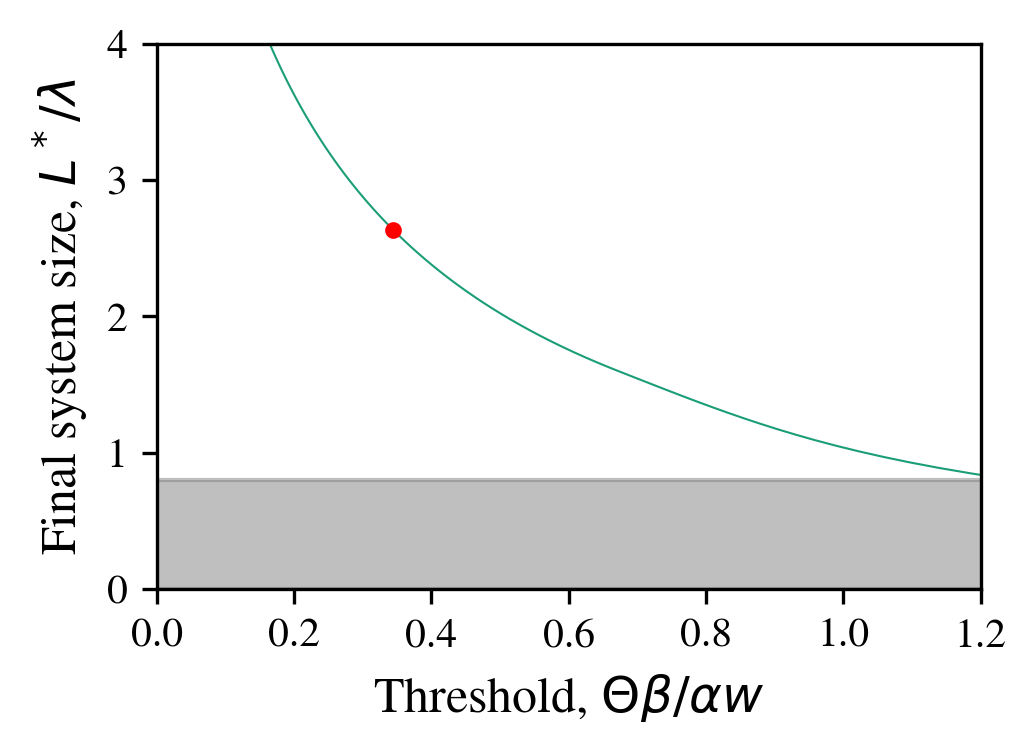

In [32]:
fig = plt.figure(figsize = default_figsize['small'])
ax = plt.subplot()

ax.plot( thresholds*beta/alpha/w, Lfinals/lam )
ax.plot( threshold_growth*beta/alpha/w,  two_morph.Lfinal(threshold_growth, x0, lam, alpha, w, beta, D)/lam, 'r.')

ax.fill_between( np.linspace(0, 2), 0, x0 + w, color='gray', alpha=0.5)
    
ax.set_xlabel(r'Threshold, $\Theta \beta / \alpha w$')
ax.set_ylabel(r'Final system size, $L^*/\lambda$')
plt.xlim( 0, 1.2 )
plt.ylim( 0, 4 )

plt.savefig('fig/two_morph_Lfinal_steady.pdf', bbox_inches='tight')

plt.show()

# Sensitivity to parameters

In [33]:
parms = {'theta': threshold_growth, 'D': D,'beta': beta, 'x0': x0, 'w': w, 'alpha': alpha}

parms_rows = { 
    0: {'theta': threshold_growth, 'D': D, 'beta': beta},
    1: {'x0':    x0,               'w': w, 'alpha': alpha}
}

Lfinal_ref = two_morph.Lfinal(threshold_growth, x0, lam, alpha, w, beta, D)

In [34]:
pc = 0.2 # percentage to variate a parameter

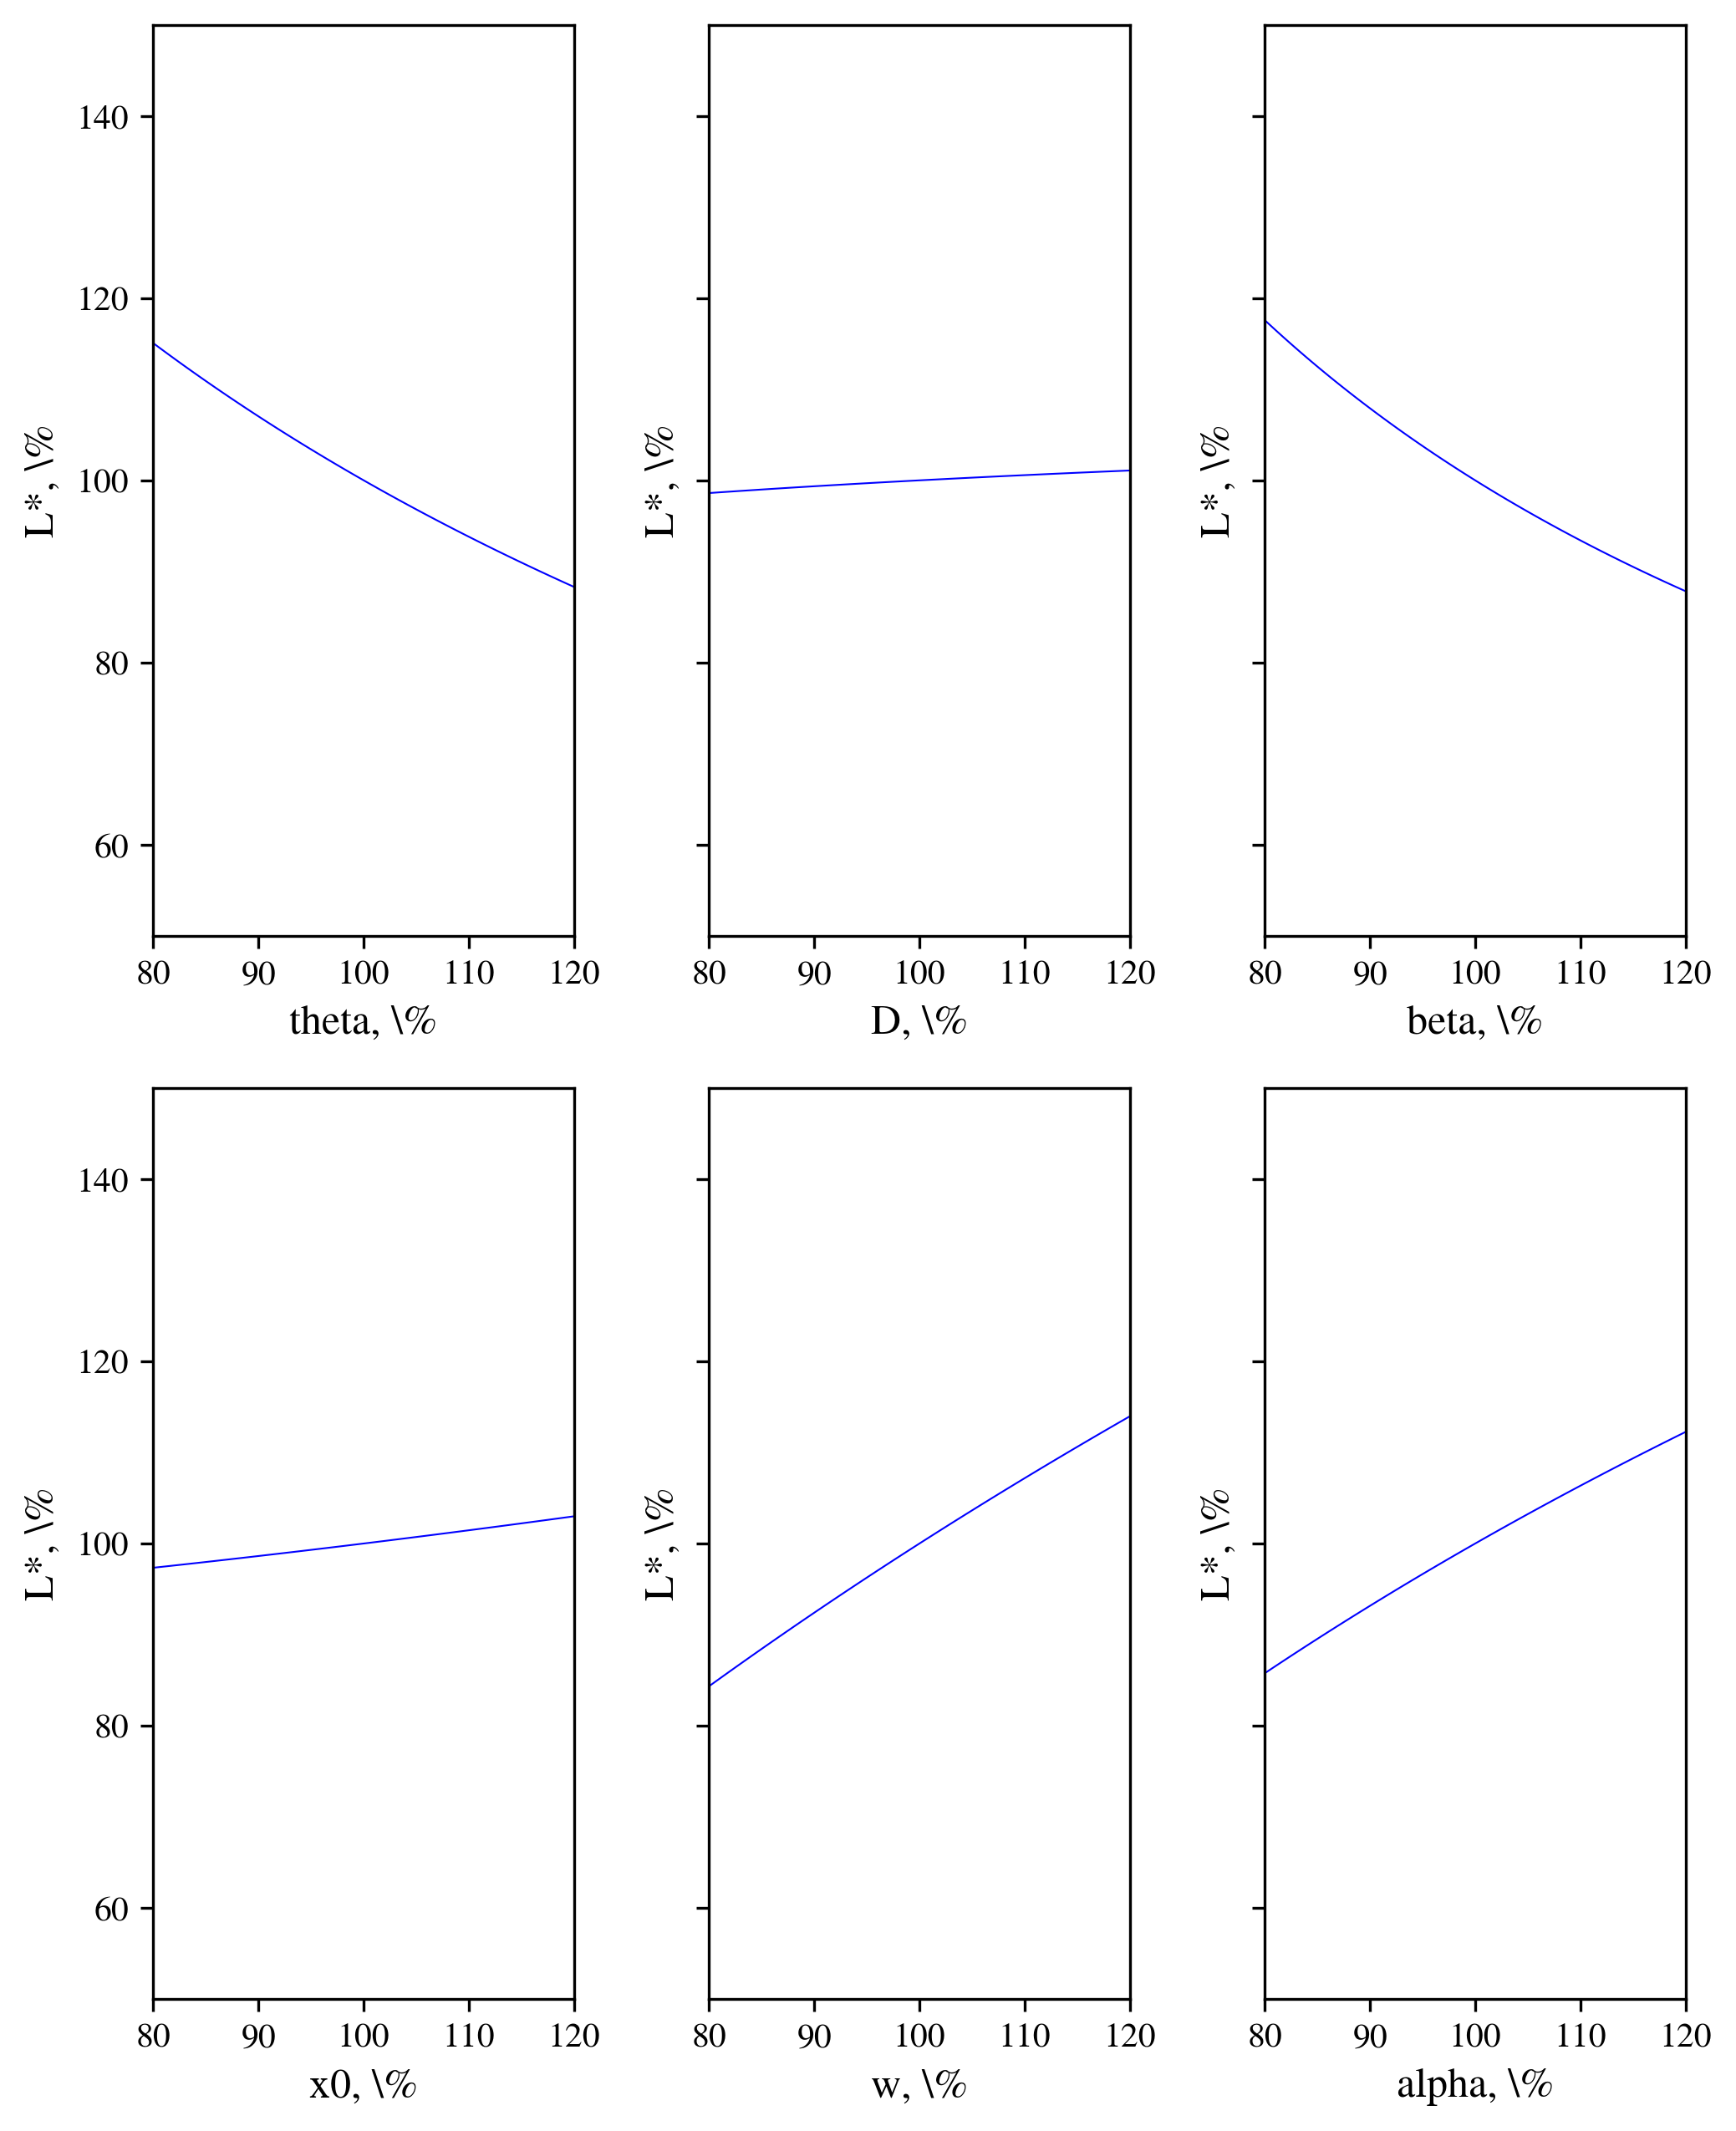

In [35]:
nrows, ncols = 2, 3
fig, ax = plt.subplots(nrows, ncols, figsize=(default_figsize["large"][0], default_figsize["large"][1]) , sharex=False, sharey=True)

for i in parms_rows.keys():
    for j, parm_name in enumerate(parms_rows[i]):
        xparm = np.linspace(
            (1 - pc) * parms[parm_name], 
            (1 + pc) * parms[parm_name], 
            100
        )

        yLfinal = []
        for value in xparm:
            temp_parms = parms.copy()
            temp_parms[parm_name] = value  
            yLfinal.append(
                 two_morph.Lfinal(
                    temp_parms['theta'], 
                    temp_parms['x0'], 
                    np.sqrt( temp_parms['D']/temp_parms['beta'] ),
                    temp_parms['alpha'], 
                    temp_parms['w'], 
                    temp_parms['beta'], 
                    temp_parms['D']
                 )
            )
        xparm   = 100 * xparm / parms[parm_name]
        yLfinal = 100 * np.array( yLfinal ) / Lfinal_ref

        ax[i, j].plot( xparm, yLfinal, 'b' )
        ax[i, j].set_xlabel( parm_name + ', \%')
        ax[i, j].set_ylabel( 'L*, \%' )
        ax[i, j].set_xlim( int((1 - pc) * 100), int((1 + pc) * 100) )
        ax[i, j].set_ylim( 50, 150 )
        
plt.savefig('fig/two_morph_sensitivity_to_parm_steady.pdf', bbox_inches='tight')

plt.tight_layout()
plt.show()